In [140]:
%%capture
%load_ext autoreload
%autoreload 2

from tqdm.notebook import trange, tqdm
from random import random
import pandas as pd
from pandas_datareader import data as web

import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal
import mplfinance as mpl

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

import tbats
import pmdarima as pm
from pmdarima.metrics import smape
from pmdarima.preprocessing import FourierFeaturizer, BoxCoxEndogTransformer
from pmdarima.arima import AutoARIMA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import prophet
import joblib

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from Pmdarima_Model import Pmdarima_Model
from regressions import *

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

import warnings
from sklearn.exceptions import FitFailedWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

In [2]:
NYSE = mcal.get_calendar('NYSE')


In [3]:
# Custom Business Hour
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: cbh=05:00-21:00>

In [4]:
# Custom Business Day
CBD = NYSE.holidays()
CBD

<CustomBusinessDay>

In [5]:
# Gather data from Yahoo Finance
symbol = 'SPY'
f_symbol = 'ES=F'

In [6]:
years = [3, 5, 10, 20, 30]
get_yf_time_series(yf, years, symbol, freq=CBD)

YF.download() has changed argument auto_adjust default to True


In [7]:
years = [3, 5, 10, 20, 30]
get_yf_time_series(yf, years, f_symbol, freq=CBD, fut=True)

## Load data from file

In [8]:
#3Y data
spy_df_3Y = load_yf_time_series(yf, 3, symbol, freq=CBD)
spy_f_df_3Y = load_yf_time_series(yf, 3, f_symbol, freq=CBD)

In [9]:
#5Y data
spy_df_5Y = load_yf_time_series(yf, 5, symbol, freq=CBD)
spy_f_df_5Y = load_yf_time_series(yf, 5, f_symbol, freq=CBD)

In [10]:
#10Y data
spy_df_10Y = load_yf_time_series(yf, 10, symbol, freq=CBD)
spy_f_df_10Y = load_yf_time_series(yf, 10, f_symbol, freq=CBD)

In [11]:
#20Y data
spy_df_20Y = load_yf_time_series(yf, 20, symbol, freq=CBD)
spy_f_df_20Y = load_yf_time_series(yf, 20, f_symbol, freq=CBD)

In [12]:
#all data
spy_df_all = load_yf_time_series(yf, 30, symbol, freq=CBD)
spy_f_df_all = load_yf_time_series(yf, 30, f_symbol, freq=CBD)

In [13]:
spy_f_df_all

,f_open,f_high,f_low,f_close,f_adj_close
date,,,,,
2000-09-18,1467.50,1489.75,1462.25,1485.25,104794.0
2000-09-19,1478.50,1482.75,1466.75,1467.00,103371.0
2000-09-20,1469.50,1480.50,1450.25,1478.75,109667.0
2000-09-21,1469.50,1474.00,1455.50,1470.25,98528.0
2000-09-22,1468.50,1471.00,1436.75,1454.75,97416.0
...,...,...,...,...,...
2025-05-12,5865.00,5876.25,5734.25,5761.00,1765593.0
2025-05-13,5904.50,5927.00,5835.75,5868.00,1335457.0
2025-05-14,5908.50,5925.00,5890.00,5902.00,1207202.0


In [14]:
tsy_symbol = 'USTREASURY/YIELD'

In [15]:
tsy_df = pd.read_csv('../data/10-year-treasury-bond-rate-yield-chart.csv', index_col='date')
tsy_df.dropna(inplace=True)
tsy_df.index = pd.to_datetime(tsy_df.index)
tsy_df.columns = ['value']

In [16]:
tsy_all_df = tsy_df.copy()
tsy_all_df.index.name = 'date'

In [17]:
tsy_all_df = tsy_all_df.sort_index().truncate(before=spy_df_all.index[0], after=spy_df_all.index[-1])
tsy_10Y_df = tsy_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
tsy_5Y_df = tsy_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
tsy_3Y_df = tsy_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [18]:
print(spy_df_all.shape)
print(spy_df_all.index)


(7563, 5)
DatetimeIndex(['1995-05-01', '1995-05-02', '1995-05-03', '1995-05-04',
               '1995-05-05', '1995-05-08', '1995-05-09', '1995-05-10',
               '1995-05-11', '1995-05-12',
               ...
               '2025-05-05', '2025-05-06', '2025-05-07', '2025-05-08',
               '2025-05-09', '2025-05-12', '2025-05-13', '2025-05-14',
               '2025-05-15', '2025-05-16'],
              dtype='datetime64[ns]', name='date', length=7563, freq='C')


In [19]:
tsy_all_df.isna().sum()

value    0
dtype: int64

In [20]:
tsy_3Y_df = tsy_3Y_df.asfreq(CBD).interpolate()
tsy_5Y_df = tsy_5Y_df.asfreq(CBD).interpolate()
tsy_10Y_df = tsy_10Y_df.asfreq(CBD).interpolate()
tsy_all_df = tsy_all_df.asfreq(CBD).interpolate()

In [21]:
tsy_all_df

,value
date,
1995-05-01,7.09
1995-05-02,7.04
1995-05-03,6.96
1995-05-04,6.85
1995-05-05,6.69
...,...
2025-04-14,4.38
2025-04-15,4.35
2025-04-16,4.29


In [22]:
tsy_all_df_6M = tsy_all_df.rename(columns={'value': '6 MO'})
tsy_all_df_1Y = tsy_all_df.rename(columns={'value': '1 Y'})
tsy_all_df_2Y = tsy_all_df.rename(columns={'value': '2 Y'})
tsy_all_df_3Y = tsy_all_df.rename(columns={'value': '3 Y'})
tsy_all_df_5Y = tsy_all_df.rename(columns={'value': '5 Y'})
tsy_all_df_7Y = tsy_all_df.rename(columns={'value': '7 Y'})
tsy_all_df_10Y = tsy_all_df.rename(columns={'value': '10 Y'})

In [23]:
tsy_3Y_df_10Y = tsy_3Y_df.rename(columns={'value': '3 Y'})

In [24]:
tsy_10Y_df_10Y = tsy_10Y_df.rename(columns={'value': '10 Y'})
tsy_10Y_df_10Y

,10 Y
date,
2015-05-01,2.12
2015-05-04,2.16
2015-05-05,2.19
2015-05-06,2.25
2015-05-07,2.18
...,...
2025-04-14,4.38
2025-04-15,4.35
2025-04-16,4.29


In [25]:
tsy_all_df_10Y

,10 Y
date,
1995-05-01,7.09
1995-05-02,7.04
1995-05-03,6.96
1995-05-04,6.85
1995-05-05,6.69
...,...
2025-04-14,4.38
2025-04-15,4.35
2025-04-16,4.29


### Inflation Indexed

In [26]:
tsy_ii_symbol = 'DFII10'  # This is the FRED symbol for the 10-Year Treasury Inflation Indexed Rate
start_date = datetime(2000, 1, 1)
end_date = datetime(2025, 1, 1)

# Fetch the data from FRED
tsy_ii_df = web.DataReader(tsy_ii_symbol, 'fred', start_date, end_date)

In [27]:
fed_df = pd.read_csv('../data/FED_10Y.csv', index_col='date')
fed_df.dropna(inplace=True)
fed_df.index = pd.to_datetime(fed_df.index)
fed_df.columns = ['value']

In [28]:
fed_all_df = fed_df.sort_index().truncate(before=spy_df_all.index[0],after=spy_df_all.index[-1])
fed_10Y_df = fed_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
fed_5Y_df = fed_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
fed_3Y_df = fed_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [29]:
fed_fund_target = 'DFEDTARU'  # This is the FRED symbol for the Federal Funds Target Rate
start_date = datetime(2008, 1, 1)  # Data available from 2008
end_date = datetime(2025, 1, 1)

# Fetch the data from FRED
fed_t_df = web.DataReader(fed_fund_target, 'fred', start_date, end_date)

# Rename columns and set index name
fed_t_df.columns = ['value']
fed_t_df.index.name = 'date'

In [30]:
fed_t_df

,value
date,
2008-12-16,0.25
2008-12-17,0.25
2008-12-18,0.25
2008-12-19,0.25
2008-12-20,0.25
...,...
2024-12-28,4.50
2024-12-29,4.50
2024-12-30,4.50


In [31]:
fed_t_all_df = fed_t_df.sort_index().truncate(before=spy_df_all.index[0],after=spy_df_all.index[-1])
fed_t_10Y_df = fed_t_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
fed_t_5Y_df = fed_t_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
fed_t_3Y_df = fed_t_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [32]:
fed_t_all_df = fed_t_all_df.asfreq(CBD)
fed_t_10Y_df = fed_t_10Y_df.asfreq(CBD)
fed_t_5Y_df = fed_t_5Y_df.asfreq(CBD)
fed_t_3Y_df = fed_t_3Y_df.asfreq(CBD)

In [33]:
fed_t_all_df.isna().sum(), fed_t_10Y_df.isna().sum(), fed_t_5Y_df.isna().sum(), fed_t_3Y_df.isna().sum()

(value    0
 dtype: int64,
 value    0
 dtype: int64,
 value    0
 dtype: int64,
 value    0
 dtype: int64)

### Exploratory Data Analysis (EDA)

In [34]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close
date,,,,,
2022-05-02,4151.00,4165.75,4056.00,4144.00,2351404
2022-05-03,4169.25,4195.75,4129.00,4145.50,1678497
2022-05-04,4295.25,4303.00,4142.75,4171.25,1783477
2022-05-05,4143.25,4300.75,4099.25,4289.75,2389422
2022-05-06,4119.50,4153.25,4062.00,4146.50,2310919
...,...,...,...,...,...
2025-05-12,5865.00,5876.25,5734.25,5761.00,1765593
2025-05-13,5904.50,5927.00,5835.75,5868.00,1335457
2025-05-14,5908.50,5925.00,5890.00,5902.00,1207202


In [35]:
spy_df_3Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
dtype: int64

In [36]:
tsy_3Y_df

,value
date,
2022-05-02,2.99
2022-05-03,2.97
2022-05-04,2.93
2022-05-05,3.05
2022-05-06,3.12
...,...
2025-04-14,4.38
2025-04-15,4.35
2025-04-16,4.29


In [37]:
df_10Y_close = pd.read_csv('../data/SPY_10Y.csv')
df_f_10Y_close = pd.read_csv('../data/SPY_F_10Y.csv')
tsy_10Y_df_10Y = pd.read_csv('../data/10-year-treasury-bond-rate-yield-chart.csv')
fed_10Y_df = pd.read_csv('../data/FED_10Y.csv')

In [38]:
df_10Y_close

,date,close
0,2015-05-01,176.183631
1,2015-05-04,177.723308
2,2015-05-05,177.555038
3,2015-05-06,176.318198
4,2015-05-07,174.938384
...,...,...
2505,2025-04-16,531.679993
2506,2025-04-17,527.640015
2507,2025-04-21,521.159973
2508,2025-04-22,520.140015


In [39]:
df_f_10Y_close

,date,f_close
0,2015-05-01,2082.75
1,2015-05-04,2101.75
2,2015-05-05,2109.50
3,2015-05-06,2085.50
4,2015-05-07,2074.75
...,...,...
2505,2025-04-16,5403.75
2506,2025-04-17,5308.00
2507,2025-04-21,5283.75
2508,2025-04-22,5182.50


In [40]:
tsy_10Y_df_10Y

,date,value
0,1993-01-29,6.39
1,1993-02-01,6.38
2,1993-02-02,6.46
3,1993-02-03,6.45
4,1993-02-04,6.39
...,...,...
8402,2025-04-15,4.35
8403,2025-04-16,4.29
8404,2025-04-17,4.34
8405,2025-04-18,NaN


In [41]:
fed_10Y_df

,date,value
0,2008-12-16,0.25
1,2008-12-17,0.25
2,2008-12-18,0.25
3,2008-12-19,0.25
4,2008-12-20,0.25
...,...,...
5968,2025-04-19,4.50
5969,2025-04-20,4.50
5970,2025-04-21,4.50
5971,2025-04-22,4.50


In [42]:
kwargs = {'data':[df_10Y_close, df_f_10Y_close, tsy_10Y_df_10Y, fed_10Y_df]}

In [43]:
data = [df_10Y_close, df_f_10Y_close, tsy_10Y_df_10Y, fed_10Y_df]

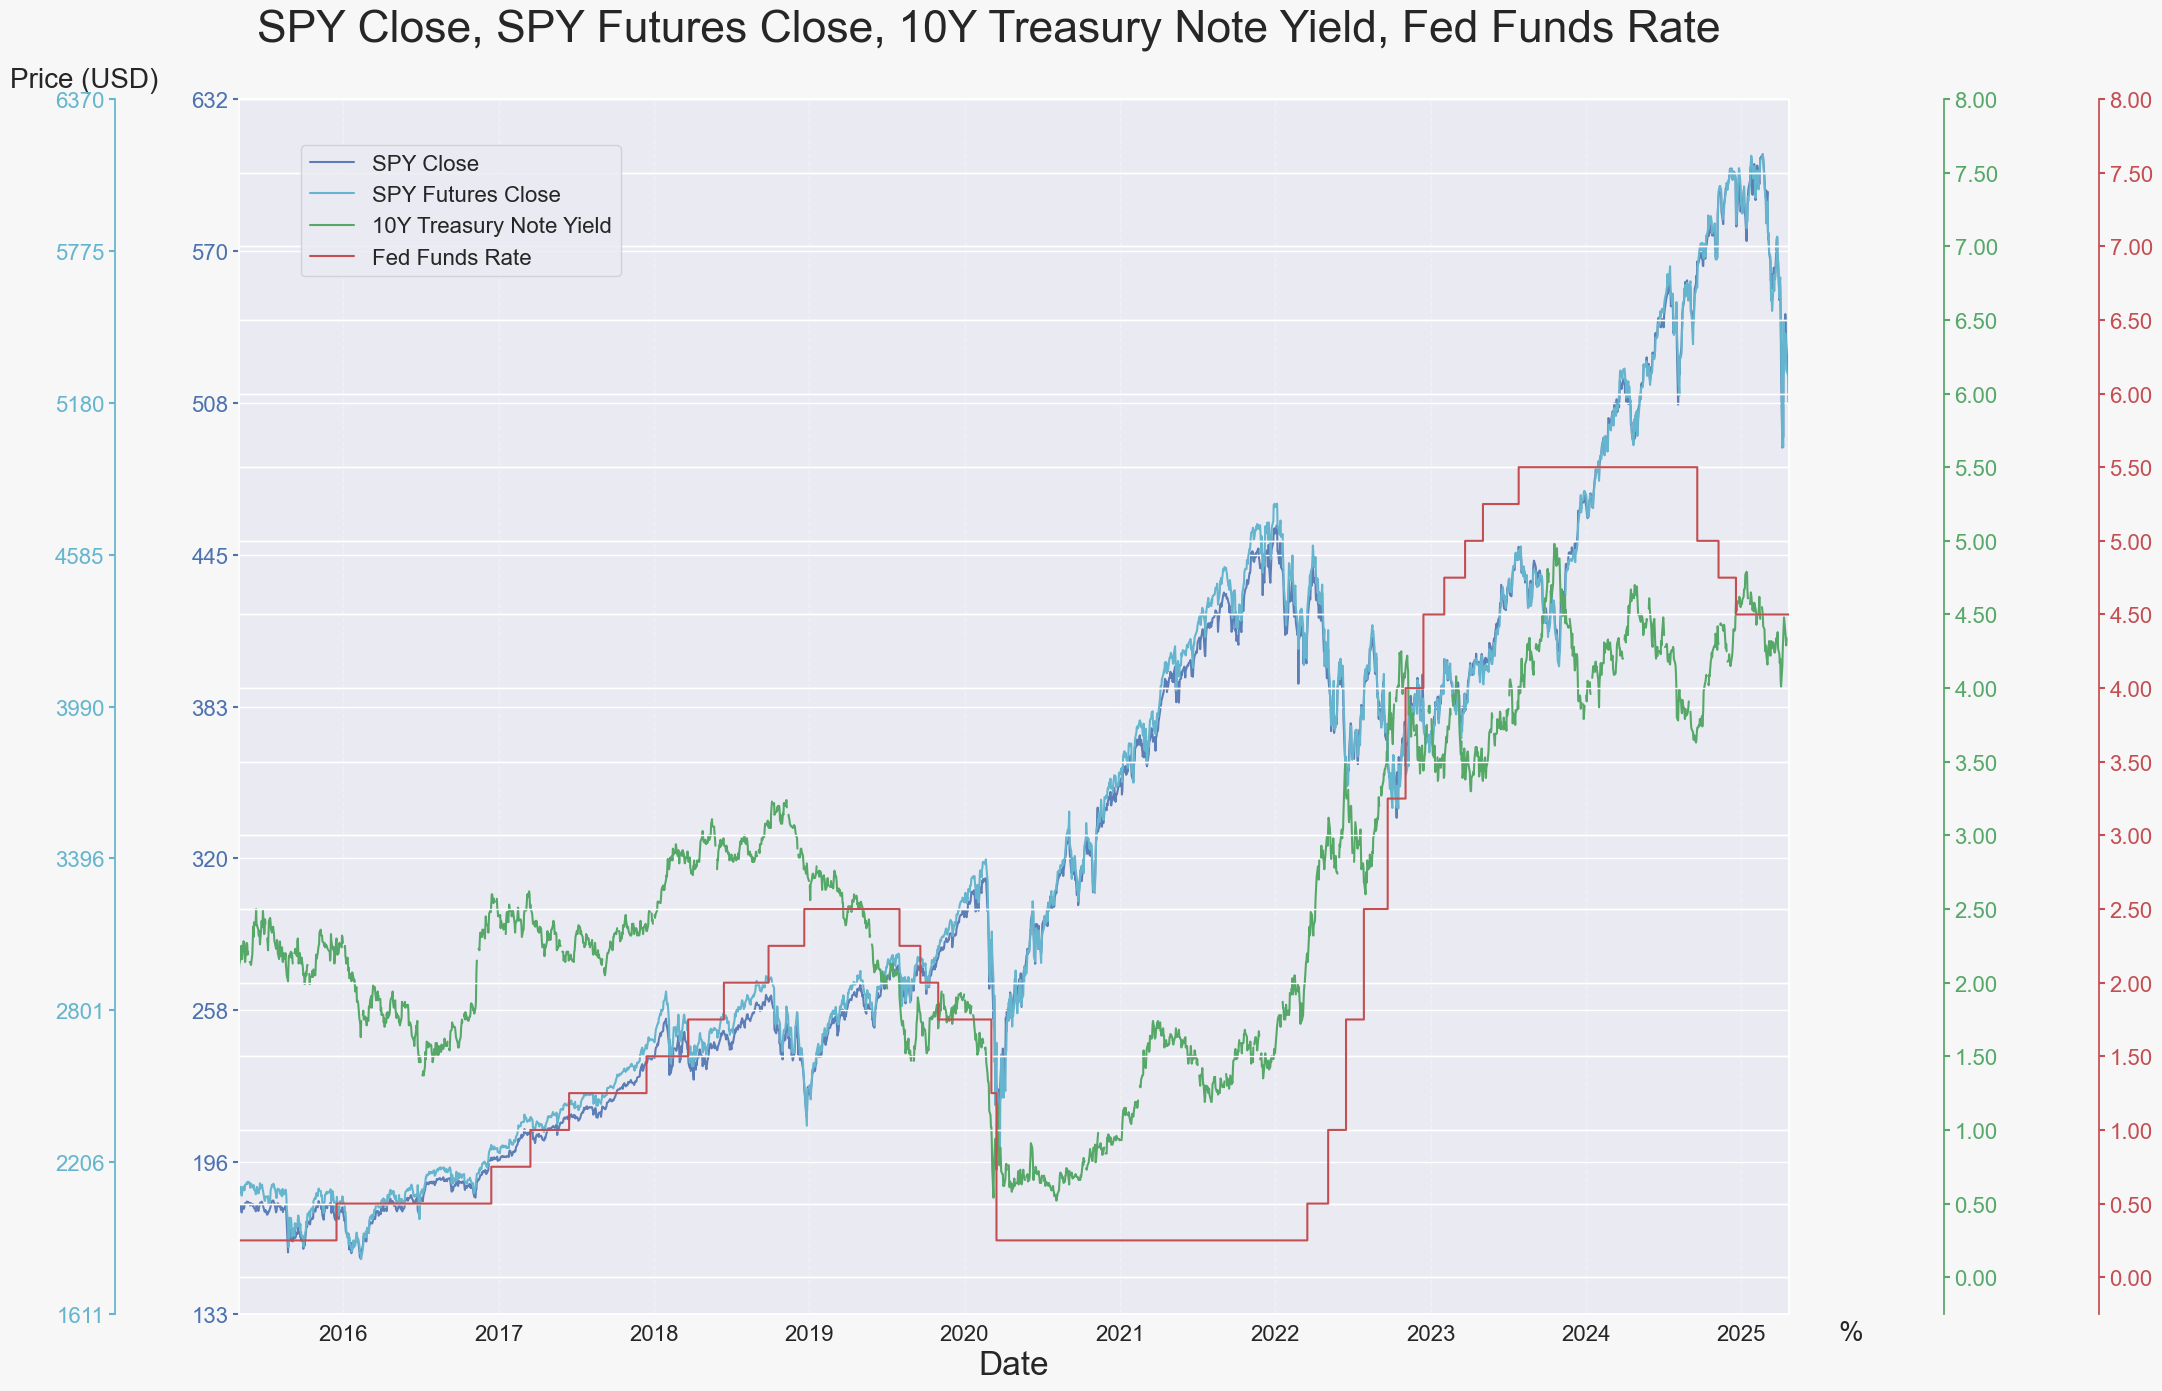

In [44]:
plot_spy_fut_tsy_funds_time_series(data)

In [45]:
spy_df_10Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
dtype: int64

In [46]:
spy_f_df_10Y

,f_open,f_high,f_low,f_close,f_adj_close
date,,,,,
2015-05-01,2101.50,2102.50,2080.50,2082.75,1022085.0
2015-05-04,2109.25,2115.00,2098.00,2101.75,1000837.0
2015-05-05,2084.00,2111.75,2081.50,2109.50,1590274.0
2015-05-06,2074.25,2093.75,2061.25,2085.50,1756254.0
2015-05-07,2084.25,2088.25,2057.00,2074.75,1437746.0
...,...,...,...,...,...
2025-05-12,5865.00,5876.25,5734.25,5761.00,1765593.0
2025-05-13,5904.50,5927.00,5835.75,5868.00,1335457.0
2025-05-14,5908.50,5925.00,5890.00,5902.00,1207202.0


In [47]:
spy_df_3Y.index[-1]

Timestamp('2025-05-16 00:00:00')

In [48]:
spy_df_5Y.truncate(before=spy_df_3Y.index[0])

,open,high,low,close,adj_close
date,,,,,
2022-05-02,396.707672,398.085929,387.653283,394.401006,158312500
2022-05-03,398.526245,400.966893,395.635720,397.214993,100028200
2022-05-04,410.662476,411.236754,395.970657,399.196152,144247900
2022-05-05,396.066437,406.776628,391.883821,406.345912,172929100
2022-05-06,393.702301,397.013933,388.332864,393.472601,151770800
...,...,...,...,...,...
2025-05-12,582.989990,583.000000,577.039978,581.469971,78993600
2025-05-13,586.840027,589.080017,582.840027,583.409973,67947200
2025-05-14,587.590027,588.979980,585.539978,587.809998,66283500


### Frequency Setup

In [49]:
spy_df_3Y = spy_df_3Y.asfreq(CBD)
spy_df_5Y = spy_df_5Y.asfreq(CBD)
spy_df_10Y = spy_df_10Y.asfreq(CBD)
spy_df_all = spy_df_all.asfreq(CBD)

In [50]:
spy_f_df_3Y = spy_f_df_3Y.asfreq(CBD)
spy_f_df_5Y = spy_f_df_5Y.asfreq(CBD)
spy_f_df_10Y = spy_f_df_10Y.asfreq(CBD)
spy_f_df_all = spy_f_df_all.asfreq(CBD)

### Impute Missing Value

In [51]:
spy_f_df_3Y = spy_f_df_3Y.interpolate()
spy_f_df_5Y = spy_f_df_5Y.interpolate()
spy_f_df_10Y = spy_f_df_10Y.interpolate()
spy_f_df_all = spy_f_df_all.interpolate()

### Create Time Series for `Close` and `Adj Close`

In [52]:
df_3Y_close = spy_df_3Y.close
df_3Y_vol = spy_df_3Y.adj_close
df_5Y_close = spy_df_5Y.close
df_5Y_vol = spy_df_5Y.adj_close
df_10Y_close = spy_df_10Y.close
df_10Y_vol = spy_df_10Y.adj_close
df_all_close = spy_df_all.close
df_all_vol = spy_df_all.adj_close

df_f_3Y_close = spy_f_df_3Y.f_close
df_f_3Y_vol = spy_f_df_3Y.f_adj_close
df_f_5Y_close = spy_f_df_5Y.f_close
df_f_5Y_vol = spy_f_df_5Y.f_adj_close
df_f_10Y_close = spy_f_df_10Y.f_close
df_f_10Y_vol = spy_f_df_10Y.f_adj_close
df_f_all_close = spy_f_df_all.f_close
df_f_all_vol = spy_f_df_all.f_adj_close

In [53]:
df_f_5Y_close, df_f_5Y_vol

(date
 2020-05-01    2871.50
 2020-05-04    2789.00
 2020-05-05    2827.00
 2020-05-06    2857.75
 2020-05-07    2832.00
                ...   
 2025-05-12    5761.00
 2025-05-13    5868.00
 2025-05-14    5902.00
 2025-05-15    5904.00
 2025-05-16    5935.00
 Freq: C, Name: f_close, Length: 1268, dtype: float64,
 date
 2020-05-01    1647259
 2020-05-04    1510680
 2020-05-05    1474765
 2020-05-06    1466641
 2020-05-07    1494330
                ...   
 2025-05-12    1765593
 2025-05-13    1335457
 2025-05-14    1207202
 2025-05-15    1291986
 2025-05-16    1291986
 Freq: C, Name: f_adj_close, Length: 1268, dtype: int64)

### Data Exploration
#### Plot PACF

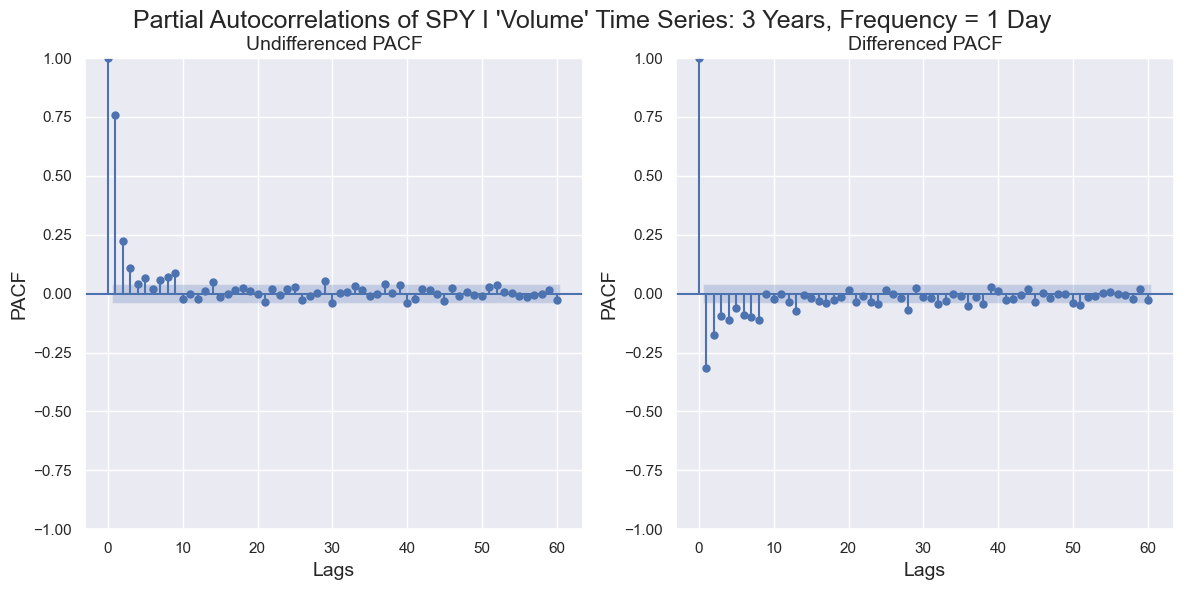

In [54]:
plot_pacf_with_diff(df_10Y_vol, 'SPY I \'Volume\'', 3, 'years', '1 Day', lags=60)

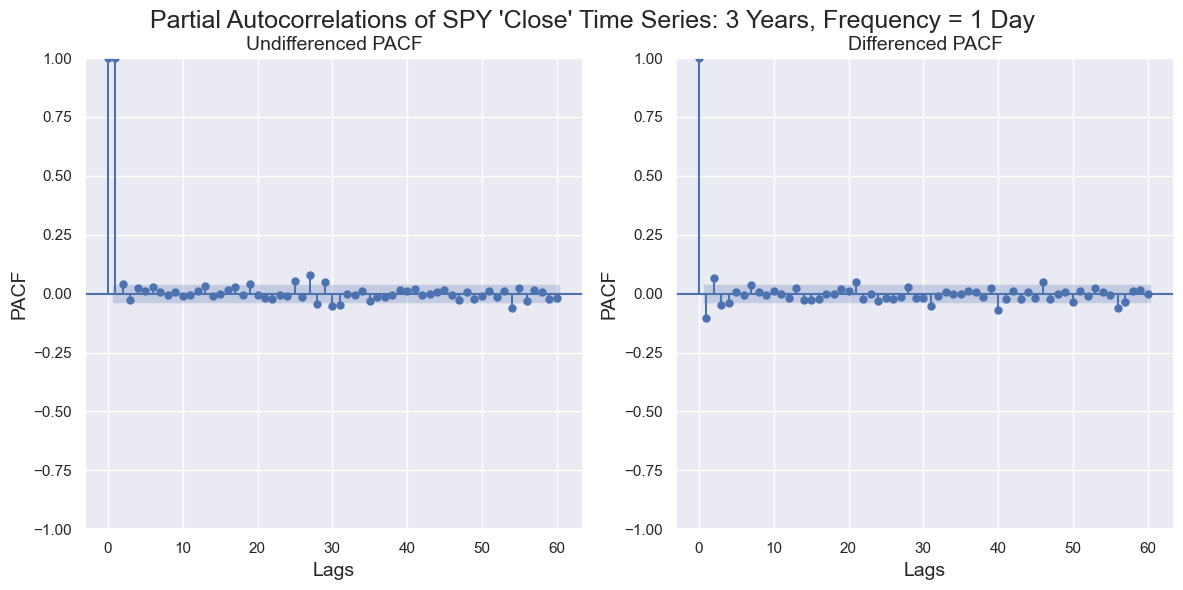

In [55]:
plot_pacf_with_diff(df_10Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

### Plot Seasonal Decomposition
#### 3 Years, Freq = Custom Business Day, Yearly Seasonality

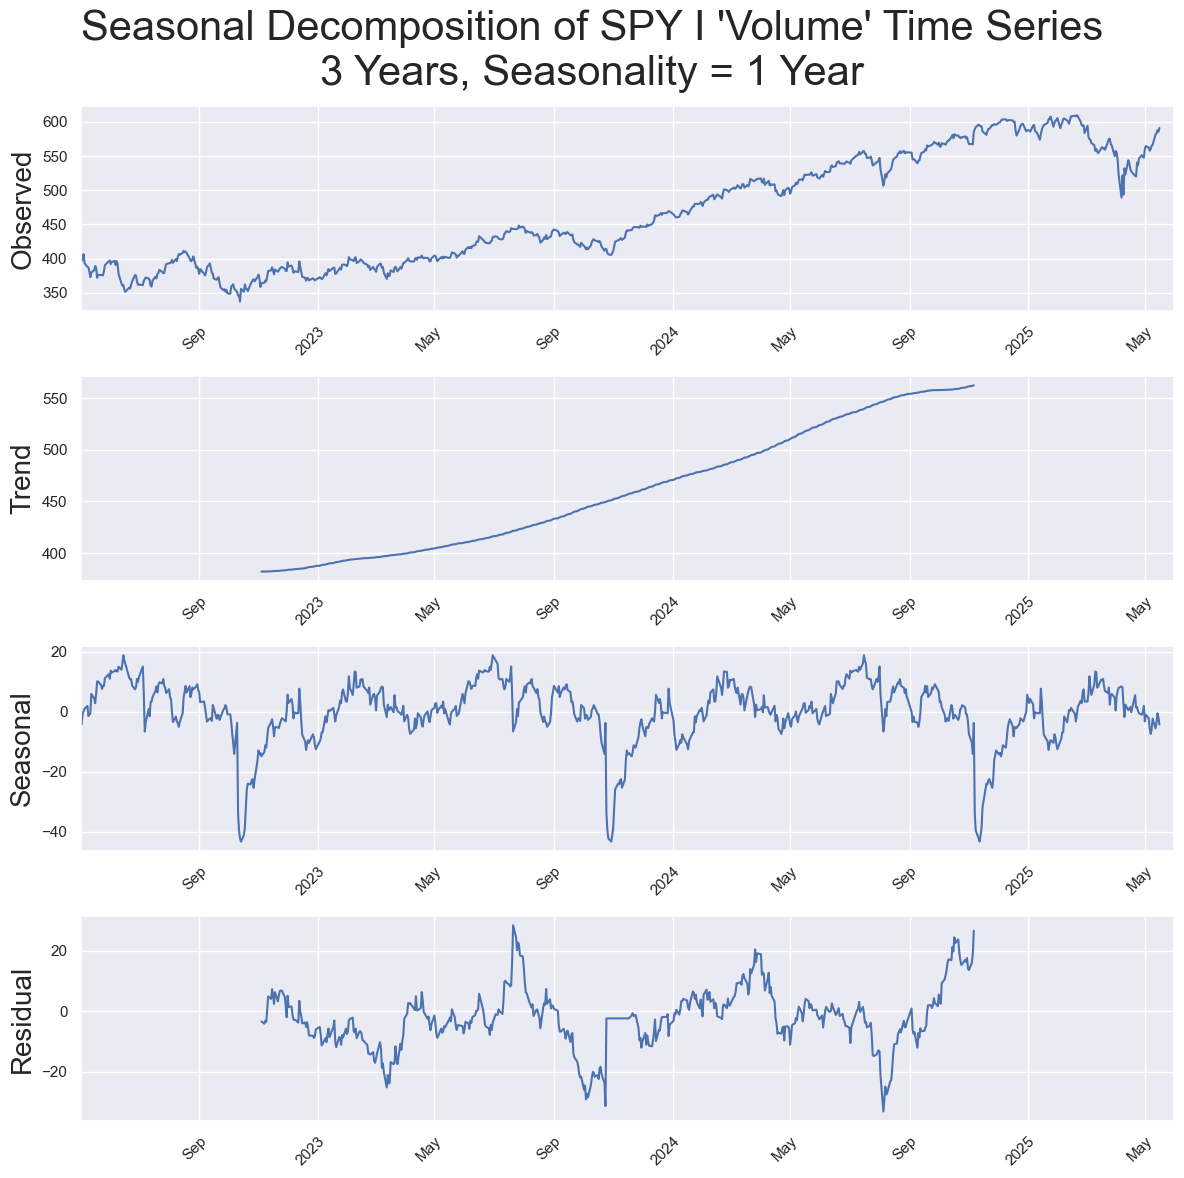

In [56]:
plot_seasonal_decomposition(df_3Y_close, 'SPY I \'Volume\'', 3, 'years', '1 Day', 261, '1 Year')

### Plot Seasonal Decomposition
#### 5 Years, Freq = Custom Business Day, Yearly Seasonality

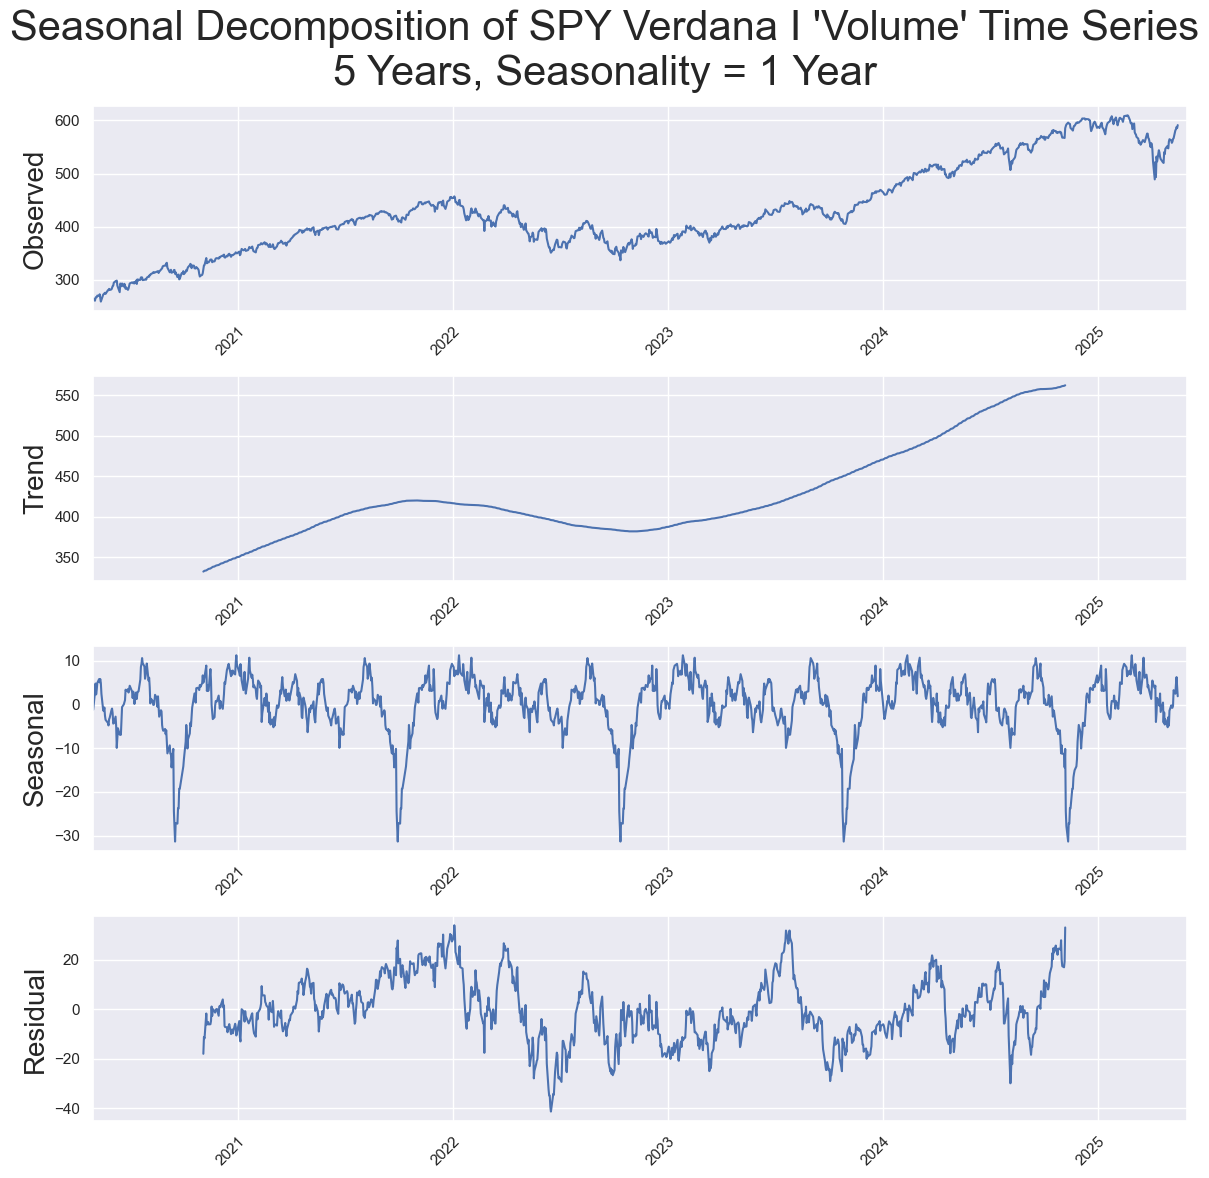

In [57]:
plot_seasonal_decomposition(df_5Y_close.dropna() , 'SPY Verdana I \'Volume\'', 5, 'years', '1 Day', 261, '1 Year')

#### 10 Years, Freq = Custom Business Day, Yearly Seasonality

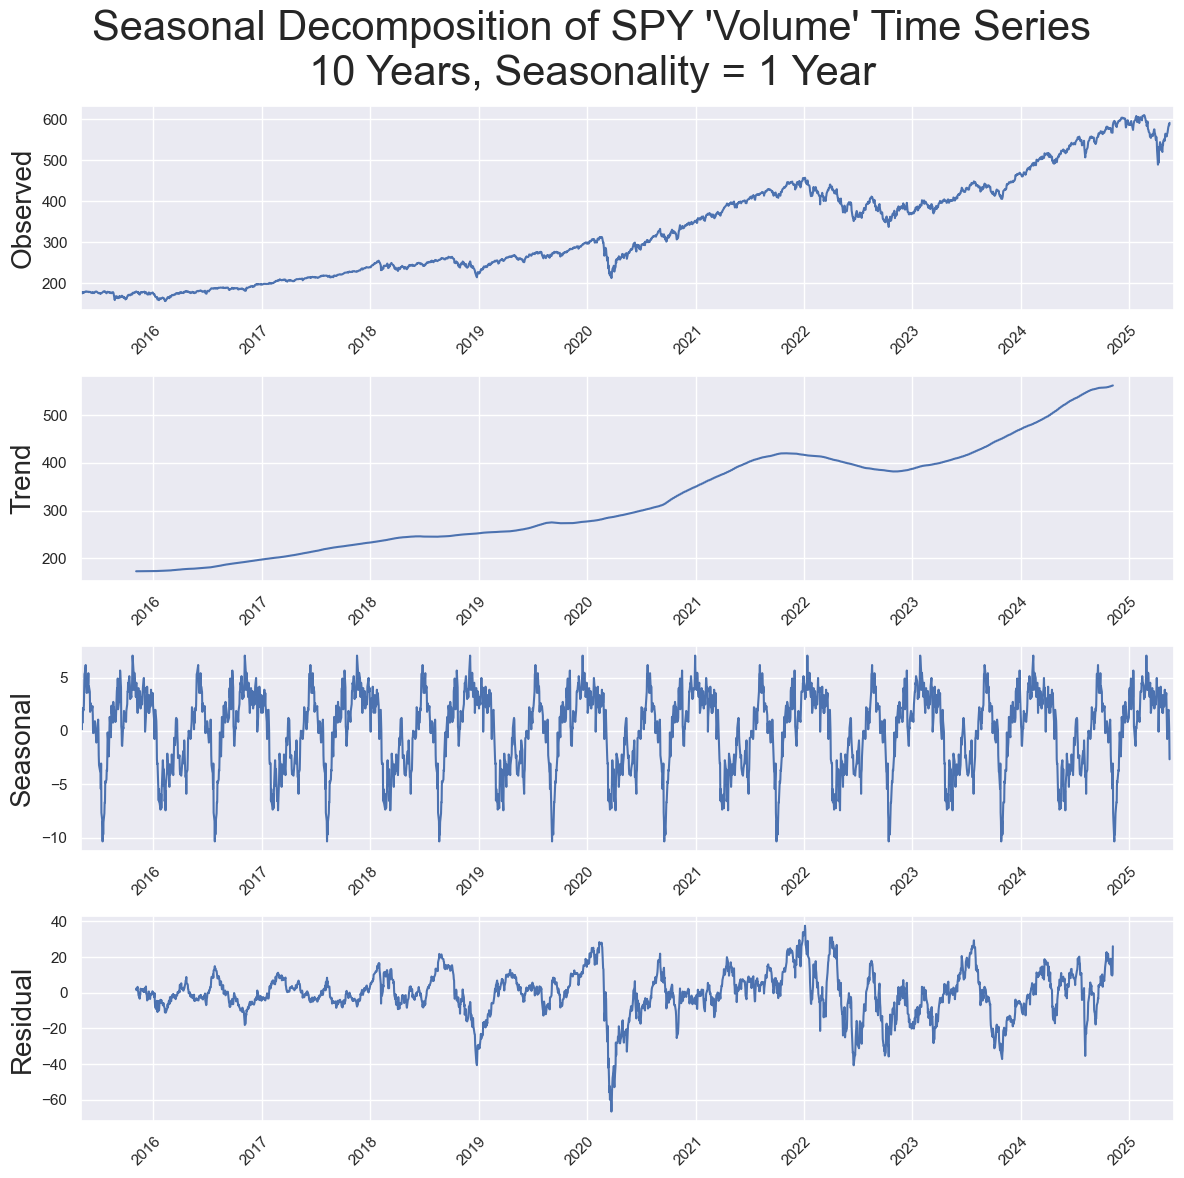

In [58]:
plot_seasonal_decomposition(df_10Y_close.dropna(), 'SPY \'Volume\'', 10, 'years', '1 Day', 261, '1 Year')

## Build DF combining SPY and SPY F

In [59]:
spy_cat_3Y_df = spy_df_3Y.join(spy_f_df_3Y)
spy_cat_3Y_df

,open,high,low,close,adj_close,f_open,f_high,f_low,f_close,f_adj_close
date,,,,,,,,,,
2022-05-02,396.707672,398.085929,387.653283,394.401006,158312500,4151.00,4165.75,4056.00,4144.00,2351404
2022-05-03,398.526184,400.966832,395.635659,397.214933,100028200,4169.25,4195.75,4129.00,4145.50,1678497
2022-05-04,410.662506,411.236785,395.970687,399.196181,144247900,4295.25,4303.00,4142.75,4171.25,1783477
2022-05-05,396.066437,406.776628,391.883821,406.345912,172929100,4143.25,4300.75,4099.25,4289.75,2389422
2022-05-06,393.702271,397.013902,388.332834,393.472571,151770800,4119.50,4153.25,4062.00,4146.50,2310919
...,...,...,...,...,...,...,...,...,...,...
2025-05-12,582.989990,583.000000,577.039978,581.469971,78993600,5865.00,5876.25,5734.25,5761.00,1765593
2025-05-13,586.840027,589.080017,582.840027,583.409973,67947200,5904.50,5927.00,5835.75,5868.00,1335457
2025-05-14,587.590027,588.979980,585.539978,587.809998,66283500,5908.50,5925.00,5890.00,5902.00,1207202


### Build DF combining the two with one day offset

In [60]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close
date,,,,,
2022-05-02,4151.00,4165.75,4056.00,4144.00,2351404
2022-05-03,4169.25,4195.75,4129.00,4145.50,1678497
2022-05-04,4295.25,4303.00,4142.75,4171.25,1783477
2022-05-05,4143.25,4300.75,4099.25,4289.75,2389422
2022-05-06,4119.50,4153.25,4062.00,4146.50,2310919
...,...,...,...,...,...
2025-05-12,5865.00,5876.25,5734.25,5761.00,1765593
2025-05-13,5904.50,5927.00,5835.75,5868.00,1335457
2025-05-14,5908.50,5925.00,5890.00,5902.00,1207202


In [61]:
spy_f_df_3Y_1d_back = spy_f_df_3Y.copy()
spy_f_df_3Y_1d_back.index = spy_f_df_3Y_1d_back.index+CBD
# spy_f_df_3Y_1d_back.drop(spy_f_df_3Y_1d_back.index[-1], axis=0, inplace=True)
spy_f_df_3Y_1d_back

C:\Users\rafli\AppData\Local\Temp\ipykernel_19656\1275101426.py:2: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  spy_f_df_3Y_1d_back.index = spy_f_df_3Y_1d_back.index+CBD


,f_open,f_high,f_low,f_close,f_adj_close
date,,,,,
2022-05-03,4151.00,4165.75,4056.00,4144.00,2351404
2022-05-04,4169.25,4195.75,4129.00,4145.50,1678497
2022-05-05,4295.25,4303.00,4142.75,4171.25,1783477
2022-05-06,4143.25,4300.75,4099.25,4289.75,2389422
2022-05-09,4119.50,4153.25,4062.00,4146.50,2310919
...,...,...,...,...,...
2025-05-13,5865.00,5876.25,5734.25,5761.00,1765593
2025-05-14,5904.50,5927.00,5835.75,5868.00,1335457
2025-05-15,5908.50,5925.00,5890.00,5902.00,1207202


In [62]:
df_1d_back = spy_df_3Y.copy()
df_1d_back = spy_f_df_3Y_1d_back.join(df_1d_back)
df_1d_back

,f_open,f_high,f_low,f_close,f_adj_close,open,high,low,close,adj_close
date,,,,,,,,,,
2022-05-03,4151.00,4165.75,4056.00,4144.00,2351404,398.526184,400.966832,395.635659,397.214933,100028200.0
2022-05-04,4169.25,4195.75,4129.00,4145.50,1678497,410.662506,411.236785,395.970687,399.196181,144247900.0
2022-05-05,4295.25,4303.00,4142.75,4171.25,1783477,396.066437,406.776628,391.883821,406.345912,172929100.0
2022-05-06,4143.25,4300.75,4099.25,4289.75,2389422,393.702271,397.013902,388.332834,393.472571,151770800.0
2022-05-09,4119.50,4153.25,4062.00,4146.50,2310919,381.097046,388.983717,379.498640,387.729890,155586100.0
...,...,...,...,...,...,...,...,...,...,...
2025-05-13,5865.00,5876.25,5734.25,5761.00,1765593,586.840027,589.080017,582.840027,583.409973,67947200.0
2025-05-14,5904.50,5927.00,5835.75,5868.00,1335457,587.590027,588.979980,585.539978,587.809998,66283500.0
2025-05-15,5908.50,5925.00,5890.00,5902.00,1207202,590.460022,590.969971,585.099976,585.559998,71268100.0


### Create Diffs DF

In [63]:
spy_cat_3Y_df_diff = pd.DataFrame(index = spy_cat_3Y_df.index)

In [64]:
spy_cat_3Y_df_diff['d_close'] = spy_cat_3Y_df.close.diff()
spy_cat_3Y_df_diff['d_f_close'] = spy_cat_3Y_df.f_close.diff()
spy_cat_3Y_df_diff['d_open'] = spy_cat_3Y_df.open.diff()
spy_cat_3Y_df_diff['d_f_open'] = spy_cat_3Y_df.f_open.diff()

In [65]:
spy_cat_3Y_df_diff

,d_close,d_f_close,d_open,d_f_open
date,,,,
2022-05-02,NaN,NaN,NaN,NaN
2022-05-03,2.813926,1.50,1.818512,18.25
2022-05-04,1.981249,25.75,12.136322,126.00
2022-05-05,7.149731,118.50,-14.596069,-152.00
2022-05-06,-12.873341,-143.25,-2.364166,-23.75
...,...,...,...,...
2025-05-12,14.989990,72.50,18.649963,187.00
2025-05-13,1.940002,107.00,3.850037,39.50
2025-05-14,4.400024,34.00,0.750000,4.00


In [66]:
spy_df_10Y.shape[0]/10

252.7

### Check Correlations between SPY and SPY Futures

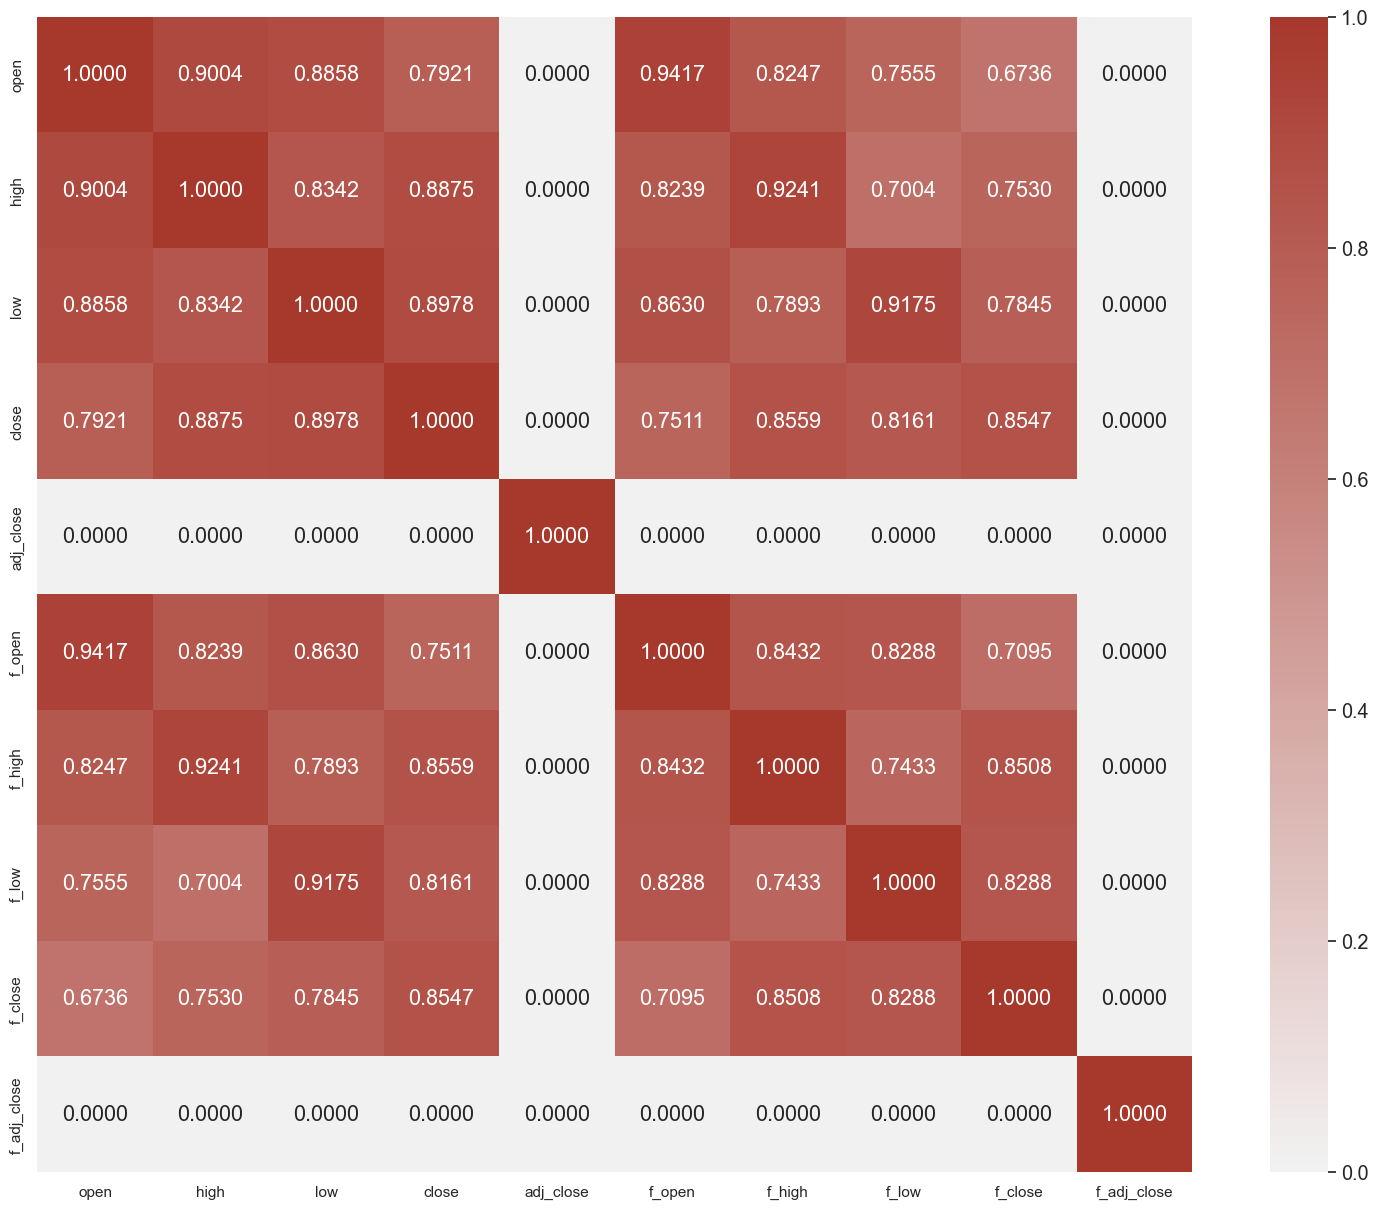

In [67]:
matrix = spy_cat_3Y_df.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**150, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')
plt.show()

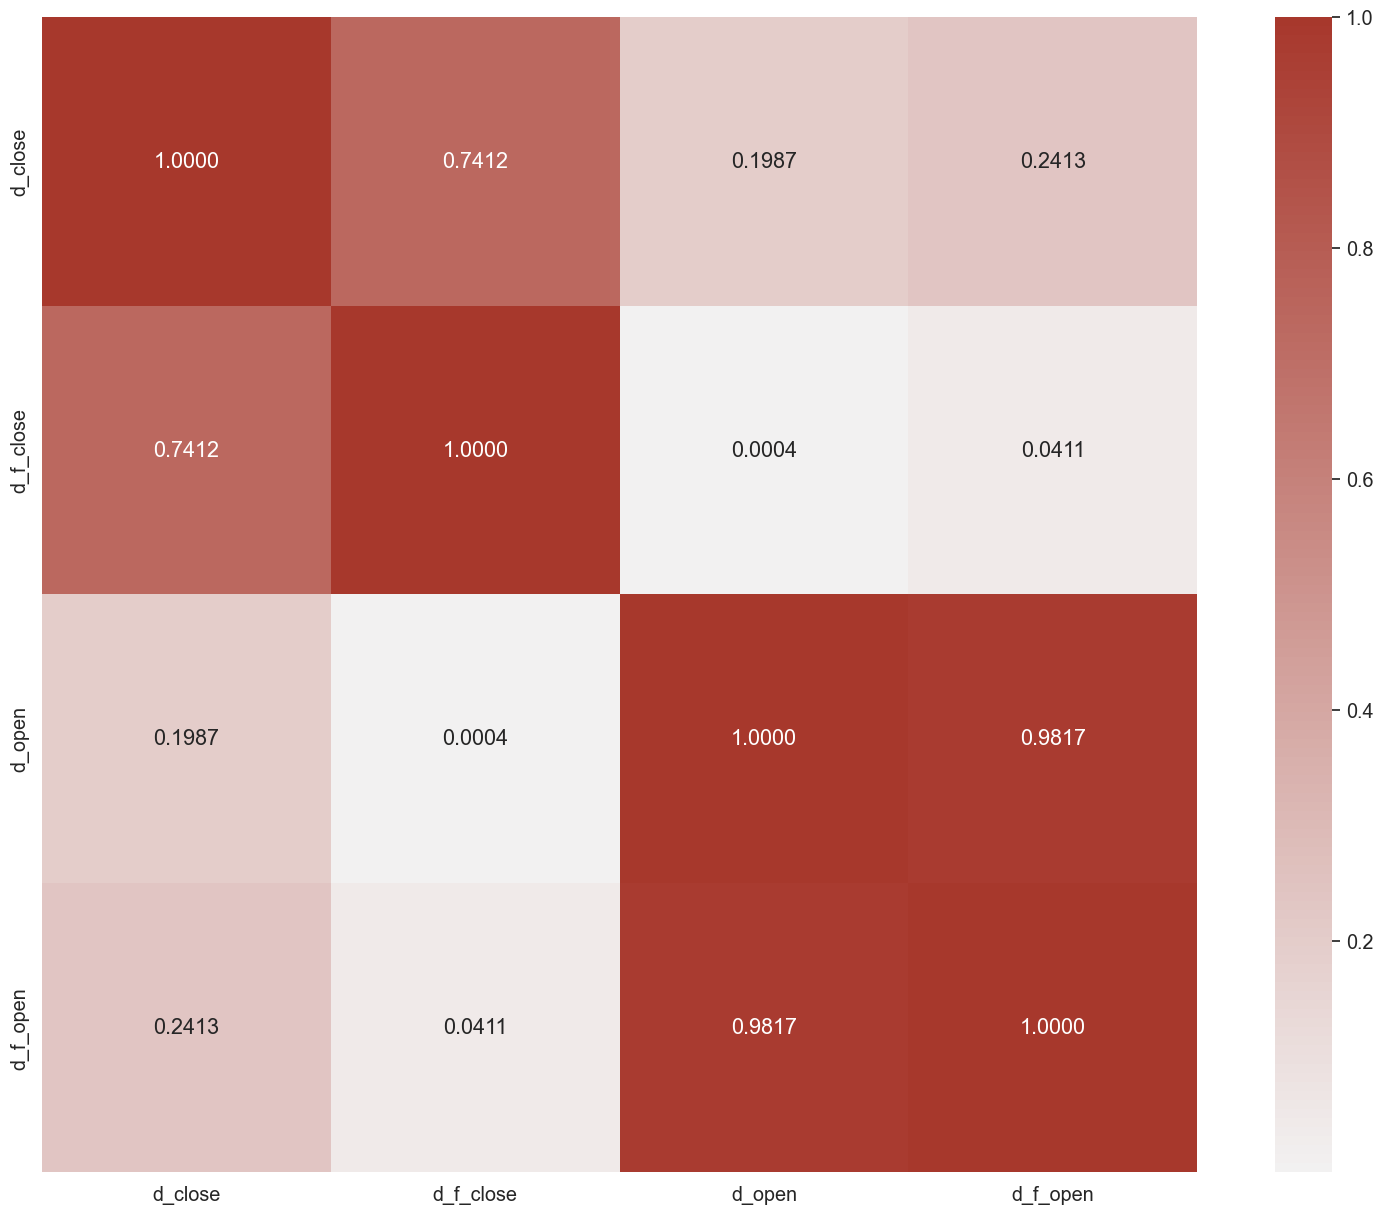

In [68]:
matrix = spy_cat_3Y_df_diff.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')
plt.show()

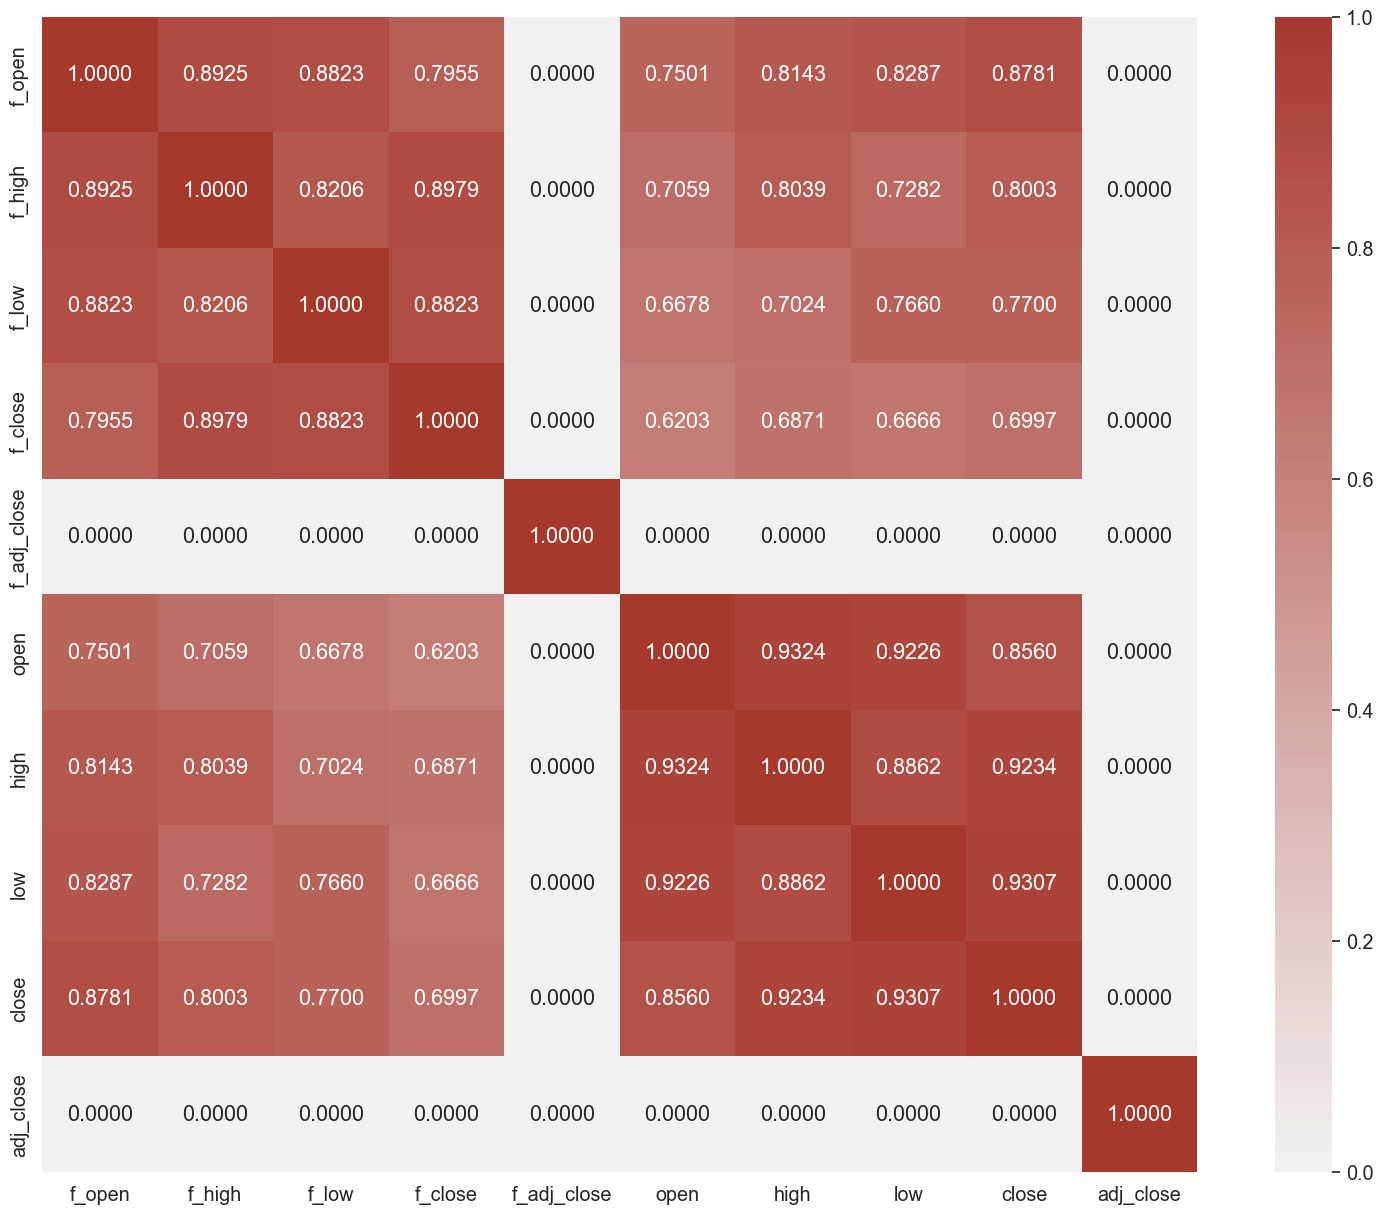

In [69]:
matrix = df_1d_back.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**100, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')
plt.show()

## Modeling
### Pmdarima
#### Treasury Exogenous Variables

In [70]:
tsy_all_df_10Y.index

DatetimeIndex(['1995-05-01', '1995-05-02', '1995-05-03', '1995-05-04',
               '1995-05-05', '1995-05-08', '1995-05-09', '1995-05-10',
               '1995-05-11', '1995-05-12',
               ...
               '2025-04-07', '2025-04-08', '2025-04-09', '2025-04-10',
               '2025-04-11', '2025-04-14', '2025-04-15', '2025-04-16',
               '2025-04-17', '2025-04-21'],
              dtype='datetime64[ns]', name='date', length=7544, freq='C')

In [71]:
pam_tsy_all_10Y = Pmdarima_Model(tsy_all_df_10Y, 'TSY 10Y Note', order=(0,1,0), trend='t',
                n='All', periods='years', freq='1 Day', f_seas=252, fit_seas=False, with_intercept=False,
                estimate_diffs=True, train_size=80, impute=False, verbose=1, k=2,
                date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


In [72]:
pam_tsy_all_10Y.conf_ints;

Explicit model pipe passed: 
       ARIMA_Order  Diffs  Mod_Order Trend  Intercept  Date  Fourier  \
Model                                                                 
0       (0, 1, 0)      1          0     t      False  True     True   

       Fourier_m  Fourier_k  BoxCox    Log  Scored   AIC  RMSE RMSE% SMAPE  \
Model                                                                        
0            252          2   False  False   False  None  None  None  None   

      CV_Time  
Model          
0        None  
Pipeline: 
 Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t', with_intercept=False))])
Fitting model... Done.
Starting step-wise cross-validation on adhoc model....
Iteratively making in-sample predictions on 'TSY 10Y Note' Time Series and updating model dynamical

Step-Wise Prediction Loop:   0%|          | 0/1509 [00:00<?, ?it/s]

> 
Done.
Test AIC: -23193.011
Test RMSE: 1.847
This is 46.518% of the avg observed value.
Test SMAPE: 66.137%

Loading best model from C:\Users\rafli\Spyder ETF Projection/models/TSY_10Y_Note_AllY_1D_adhoc_best_model.pkl.
Model outperforms existing best adhoc model at C:\Users\rafli\Spyder ETF Projection/models/TSY_10Y_Note_AllY_1D_adhoc_best_model.pkl, overwriting.
Attempting to add a new score to file... Model found in file. Already scored. Nothing to do. 


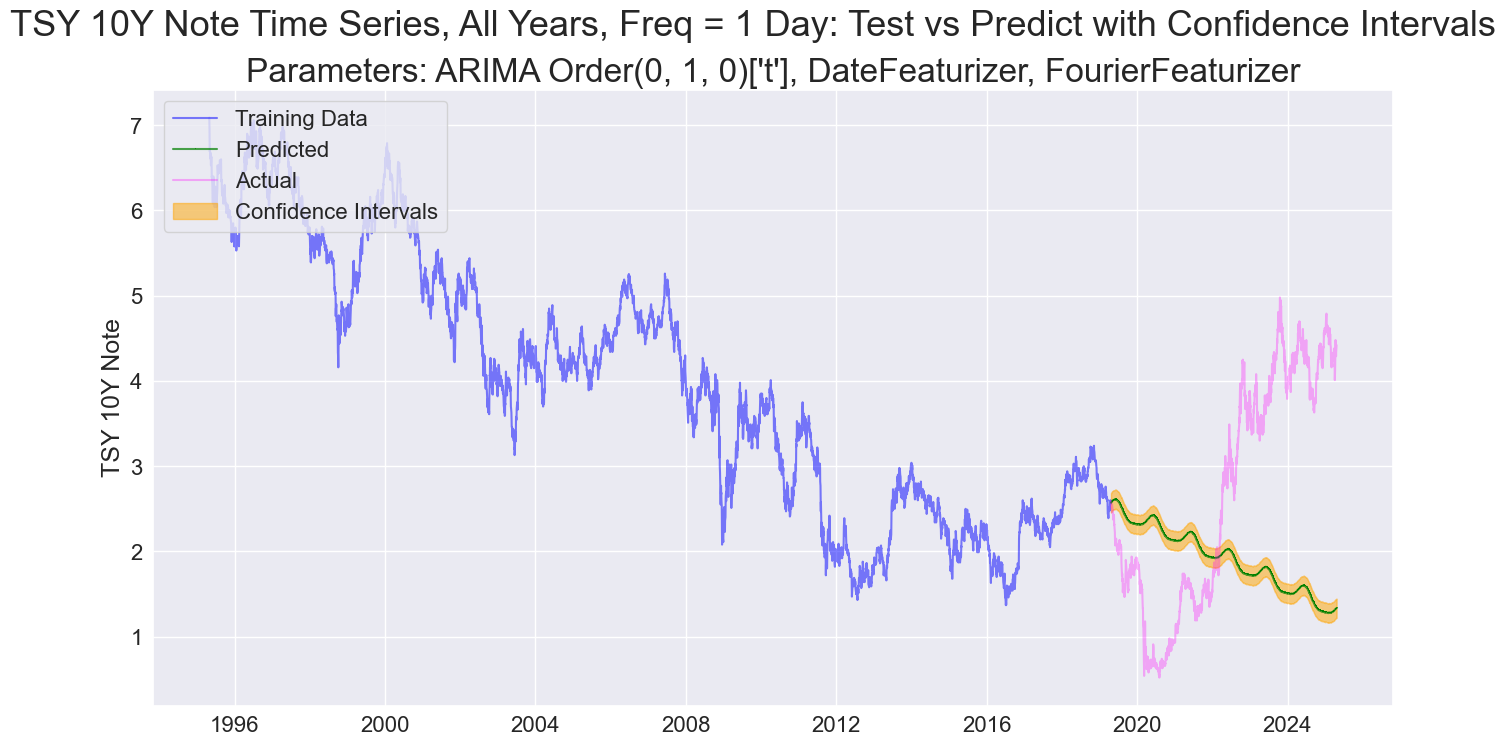

In [73]:
AIC, RMSE, RMSE_pc, SMAPE = pam_tsy_all_10Y.run_stepwise_CV(func='adhoc', dynamic=True, verbose=1, visualize=True, max_models=1)

Starting AutoARIMA...
Data set diffs to use: 1


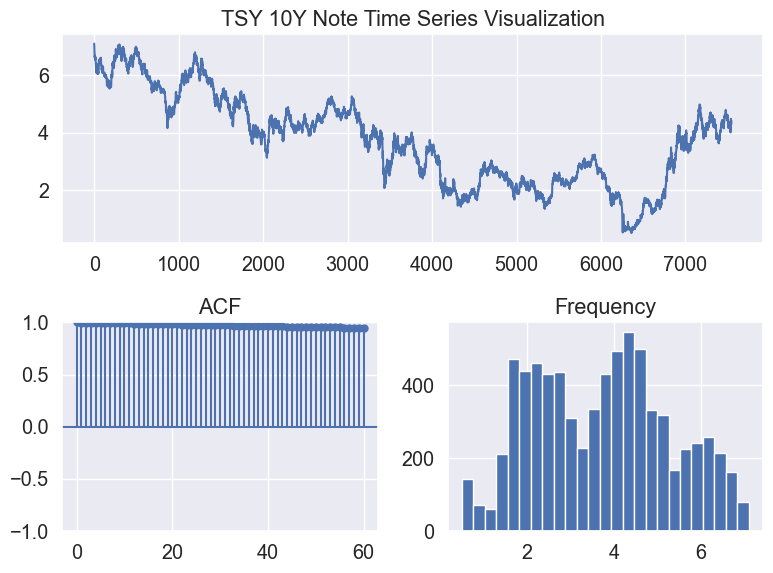

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=False))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-17341.698, Time=8.75 sec
First viable model found (-17341.698)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17342.136, Time=8.13 sec
New best model found (-17342.136 < -17341.698)
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17341.376, Time=4.89 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-17341.441, Time=3.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-17340.216, Time=3.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17341.148, Time=2.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 31.938 seconds
Best params:
  ARIMA(0, 1, 0), 

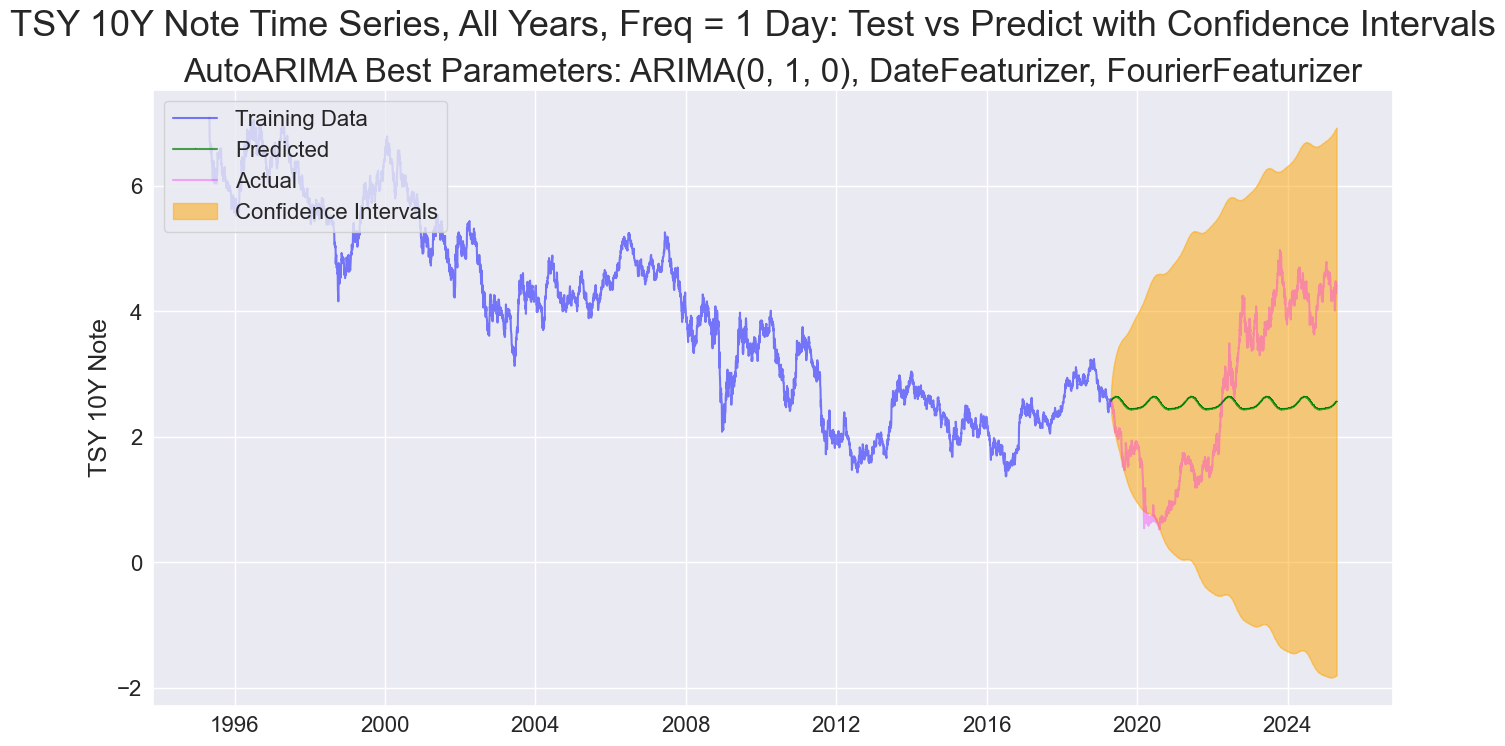

In [74]:
pam_tsy_all_10Y_AA_pipe = pam_tsy_all_10Y.run_auto_pipeline(show_summary=True, verbose=1, visualize=True)

ARIMA(0, 1, 0), DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=False))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making in-sample predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


Step-Wise Prediction Loop:   0%|          | 0/1509 [00:00<?, ?it/s]

> 
Done.
Test AIC: -21498.966
Test RMSE: 0.061
This is 1.534% of the avg observed value.
Test SMAPE: 2.206%

Loading best model from C:\Users\rafli\Spyder ETF Projection/models/TSY_10Y_Note_AllY_1D_AA_best_model.pkl.
Model outperforms existing best AutoARIMA model at C:\Users\rafli\Spyder ETF Projection/models/TSY_10Y_Note_AllY_1D_AA_best_model.pkl, overwriting.
Attempting to add a new score to file... Model not already present in file. Appending model scores to file. 



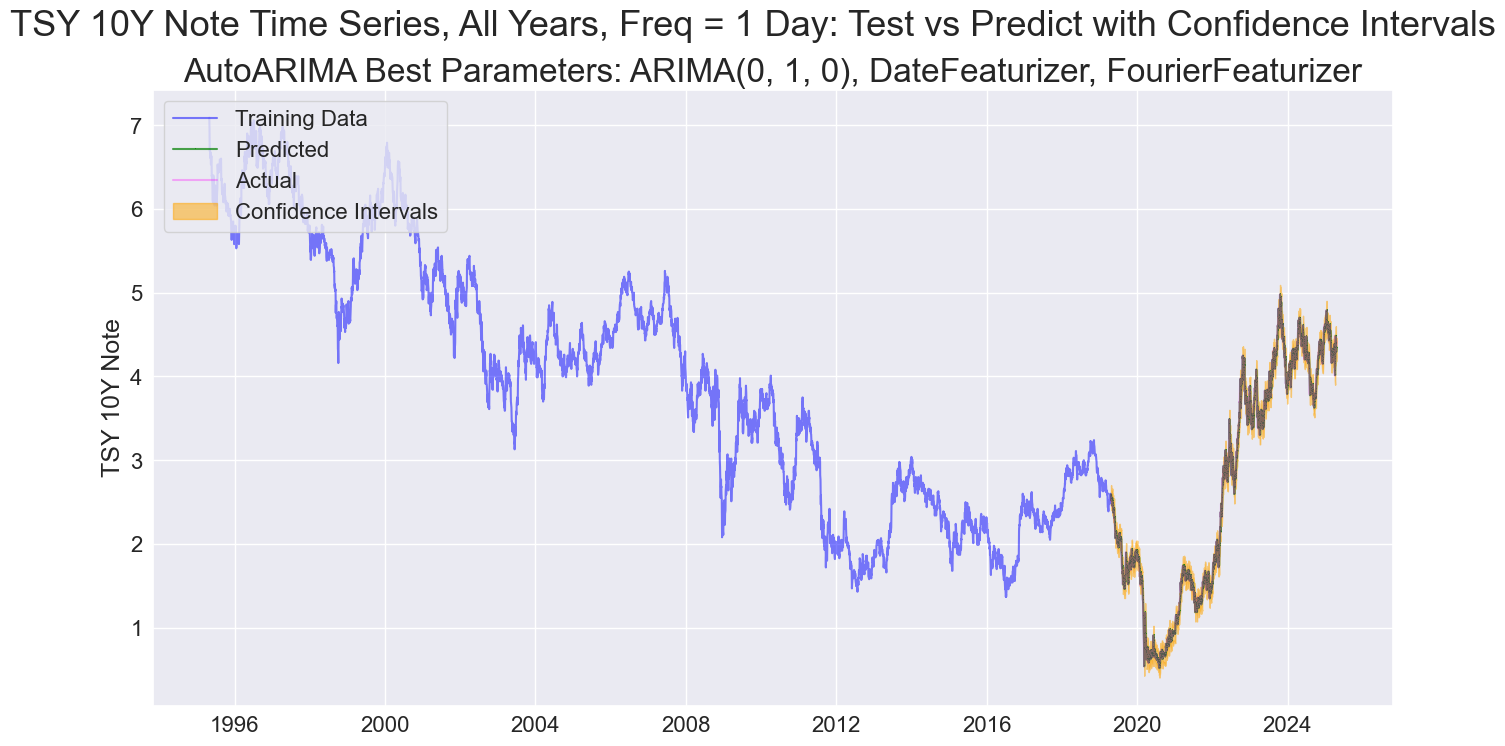

In [75]:
AIC, RMSE, RMSE_pc, SMAPE = pam_tsy_all_10Y.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

Setting up GridSearchCV...
Reached 1 models, ending grid-building.
Based on parameters given, 0 models built out of 8 in grid.
Running normally.
Running step-wise cross-validation on model 1 of 1... Done.
Model[ARIMA Order(0, 0, 1)['n'], DateFeaturizer]: AIC=18029.653 | RMSE=0.909 | RMSE_pc=22.883% | SMAPE=35.670%
GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 0, 1)['n'], DateFeaturizer]: AIC=18029.653 | RMSE=0.909 | RMSE%=22.883% | SMAPE=35.670%


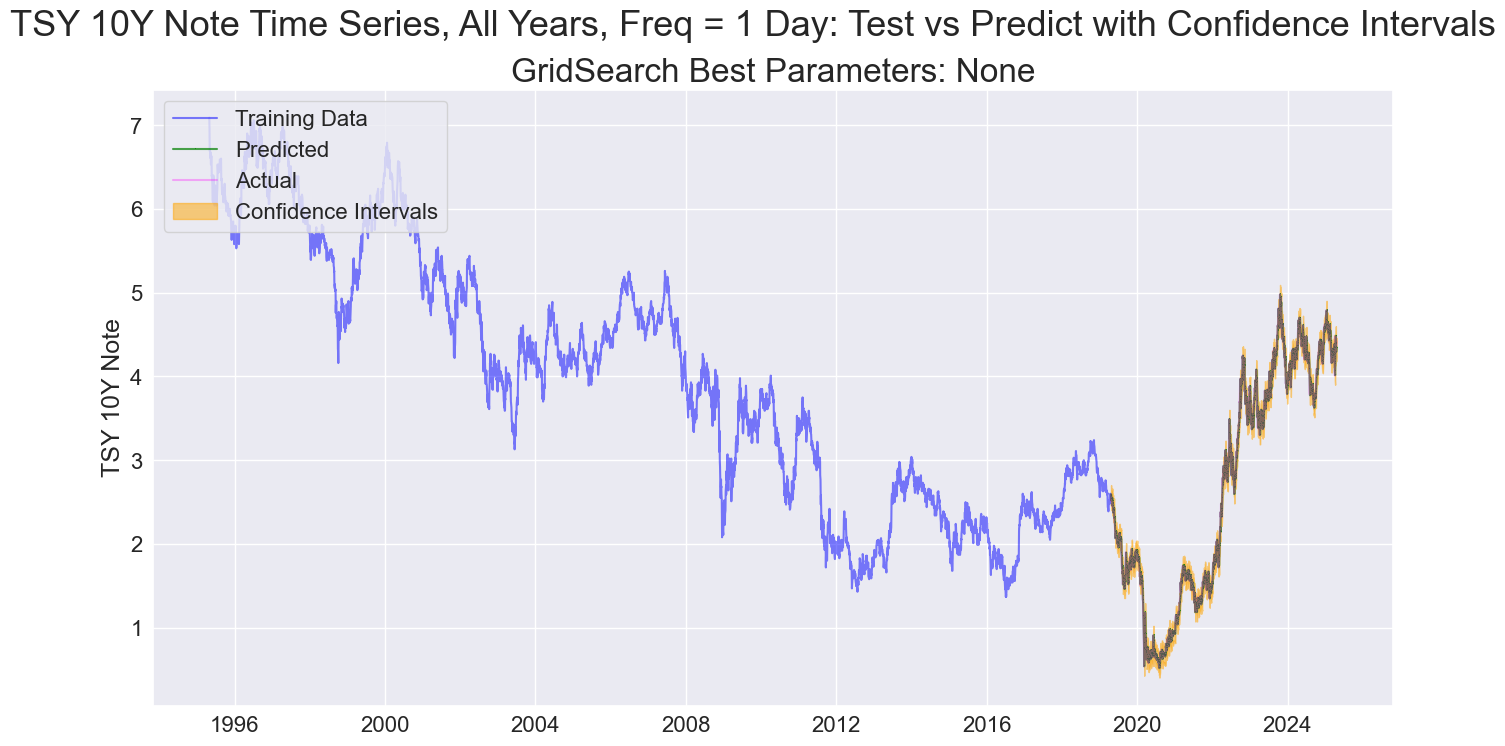

In [76]:
pam_tsy_3Y_10Y_best, scores = pam_tsy_all_10Y.run_gridsearch_CV(min_order=0, max_order=1, min_d=0, max_d=0, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', f_m=252, # k=2,
                                    fourier=False, box=False, log=False, debug=False, verbose=0, parallel=False)

### Effective Funds Rate

Successfully created instance of Class Pmdarima_Model.
Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 1, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model

Model Loop:   0%|          | 0/1 [00:00<?, ?it/s]

________________________________________________________________________

Running step-wise cross-validation on model 1 of 1... 
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making in-sample predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


Step-Wise Prediction Loop:   0%|          | 0/1195 [00:00<?, ?it/s]

> 
Done.
AIC: -22457.808 | RMSE: 0.054 | RMSE%=8.388% | SMAPE 0.318%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=-22457.808 | RMSE=0.054 | RMSE_pc=8.388% | SMAPE=0.318%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=0.054
Loading best model from C:\Users\rafli\Spyder ETF Projection/models/Fed_Funds_Effective_Rate_10Y_1D_GS_best_model.pkl.
Model outperforms existing best GridSearchCV model at C:\Users\rafli\Spyder ETF Projection/models/Fed_Funds_Effective_Rate_10Y_1D_GS_best_model.pkl, overwriting.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 6.
Adding scores to model, updating line 6.
GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=-22457.808 | RMSE=0.054 | RMSE%=8.388% | SMAPE=0.318%


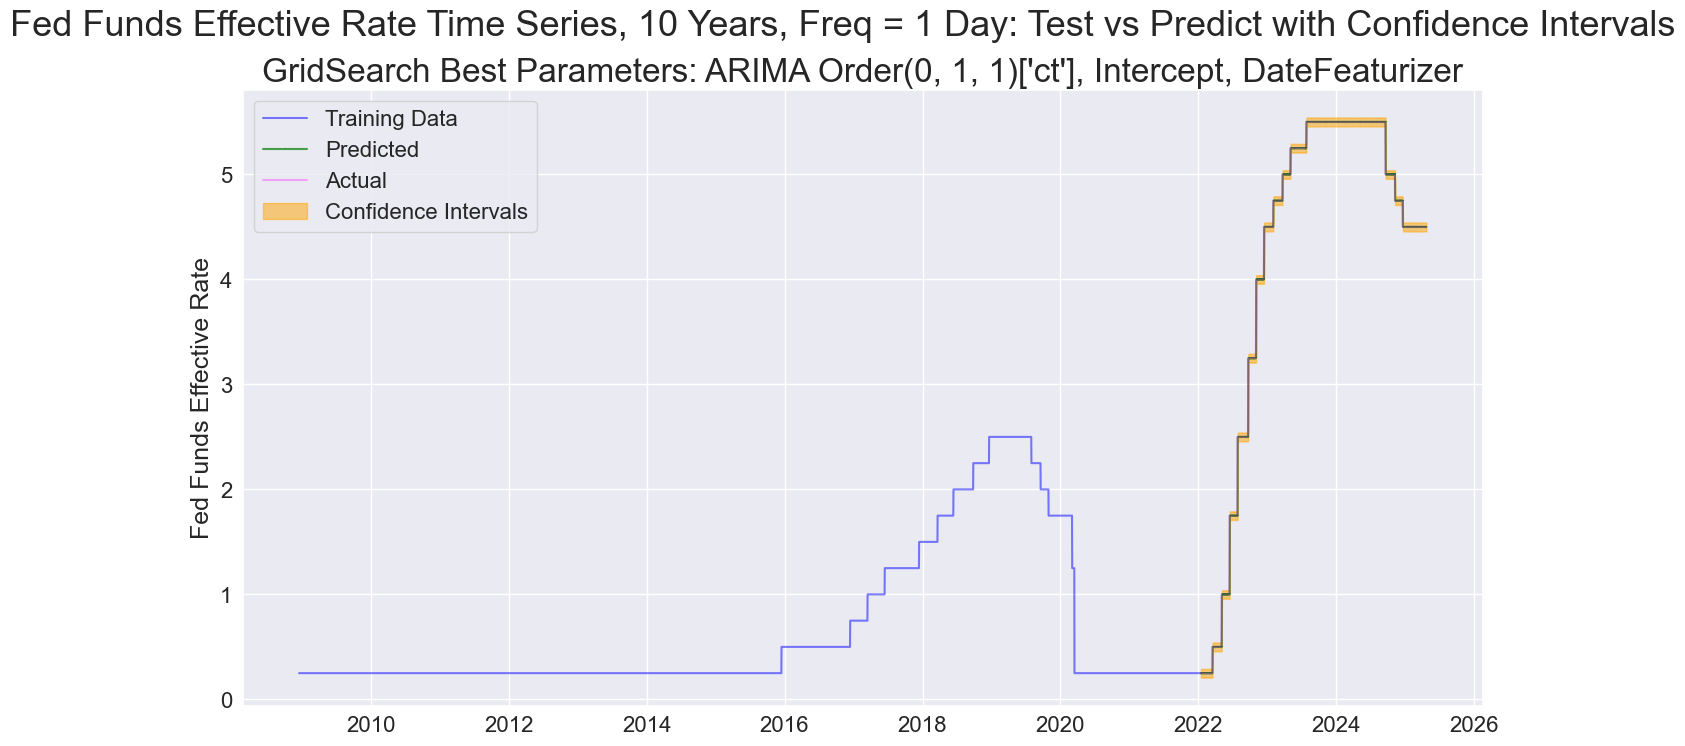

In [85]:
pam_fed_funds_10Y = Pmdarima_Model(fed_10Y_df, 'Fed Funds Effective Rate', order=(0,1,0), trend='t',
               n=10, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=False, box=False, log=False)
pam_fed_funds_10Y_best, scores = pam_fed_funds_10Y.run_gridsearch_CV(min_order=0, max_order=2, min_d=1, max_d=1, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', #f_m=252, k=2,
                                    fourier=False, box=False, log=False, debug=True, verbose=1, parallel=False)

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
Reached 1 models, ending grid-building.
Based on parameters given, 0 models built out of 3 in grid.
Starting iterative search through all GridSearch params.
Running normally.


Model Loop:   0%|          | 0/1 [00:00<?, ?it/s]

________________________________________________________________________

Running step-wise cross-validation on model 1 of 1... 
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making in-sample predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


Step-Wise Prediction Loop:   0%|          | 0/1195 [00:00<?, ?it/s]

> 
Done.
AIC: 19532.638 | RMSE: 2.516 | RMSE%=393.285% | SMAPE 75.014%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=19532.638 | RMSE=2.516 | RMSE_pc=393.285% | SMAPE=75.014%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 26.
Adding scores to model, updating line 26.
GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=19532.638 | RMSE=2.516 | RMSE%=393.285% | SMAPE=75.014%


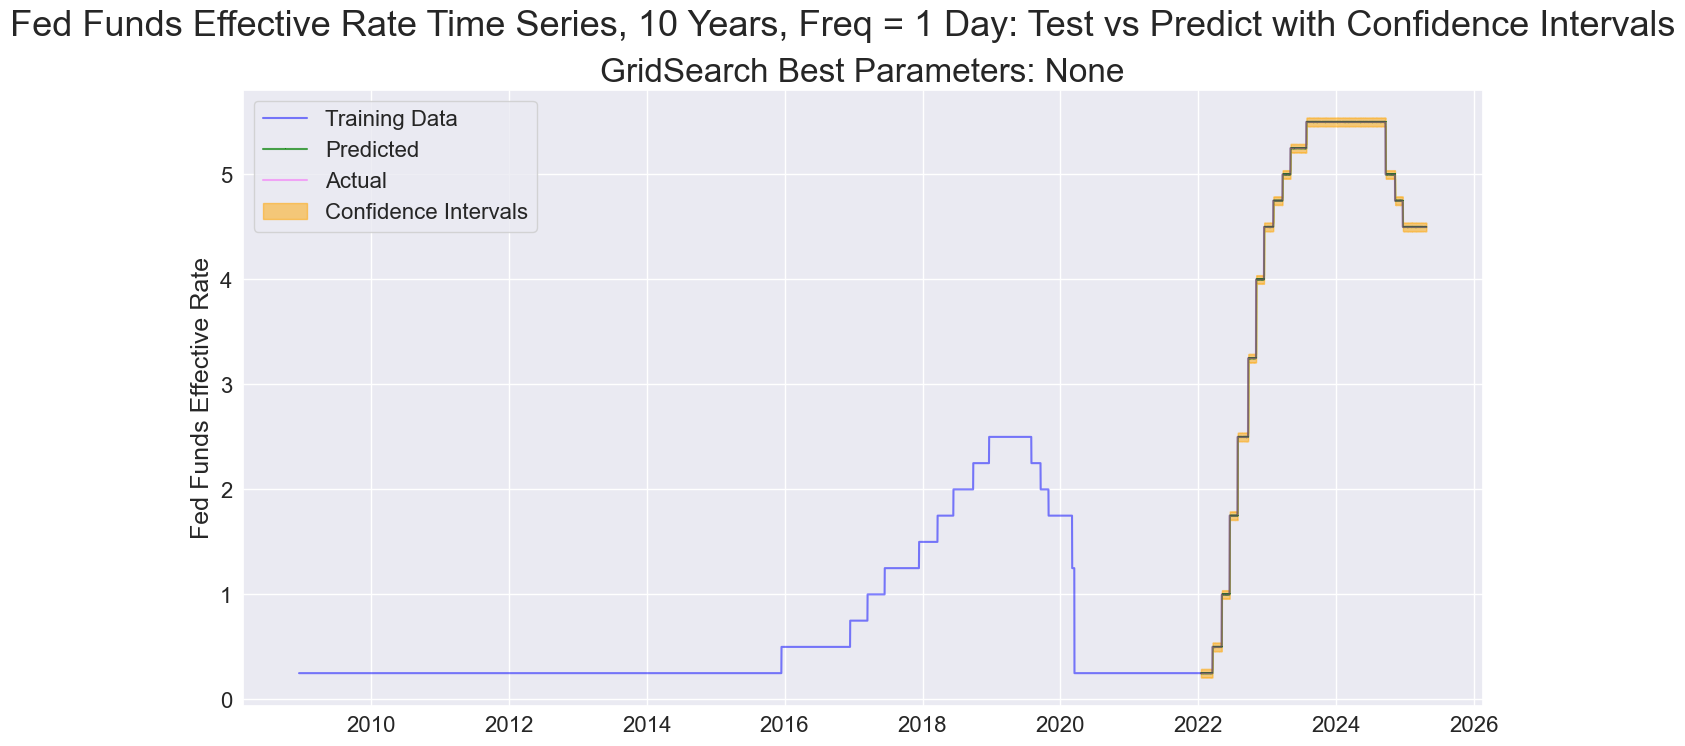

In [86]:
pam_fed_funds_10Y_best, scores = pam_fed_funds_10Y.run_gridsearch_CV(min_order=0, max_order=1, min_d=0, max_d=1, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', #f_m=252, k=2,
                                    fourier=False, box=False, log=False, debug=True, verbose=1, parallel=False)

### Fed Funds Rate Target - Upper Limit

Successfully created instance of Class Pmdarima_Model.
Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
Reached 1 models, ending grid-building.
Based on parameters given, 0 models built out of 4 in grid.
Starting iterative search through all GridSearch param

Model Loop:   0%|          | 0/1 [00:00<?, ?it/s]

________________________________________________________________________

Running step-wise cross-validation on model 1 of 1... 
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making in-sample predictions on 'Fed Funds Target Rate' Time Series and updating model, beginning with first index of y_test ...


Step-Wise Prediction Loop:   0%|          | 0/487 [00:00<?, ?it/s]

> 
Done.
AIC: 10006.076 | RMSE: 3.714 | RMSE%=323.428% | SMAPE 108.004%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['n'], DateFeaturizer]: AIC=10006.076 | RMSE=3.714 | RMSE_pc=323.428% | SMAPE=108.004%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=3.714
Loading best model from C:\Users\rafli\Spyder ETF Projection/models/Fed_Funds_Target_Rate_10Y_1D_GS_best_model.pkl.
Model outperforms existing best GridSearchCV model at C:\Users\rafli\Spyder ETF Projection/models/Fed_Funds_Target_Rate_10Y_1D_GS_best_model.pkl, overwriting.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 3.
Adding scores to model, updating line 3.
GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 0, 0)['n'], DateFeaturizer]: AIC=10006.076 | RMSE=3.714 | RMSE%=323.428% | SMAPE=108.004%


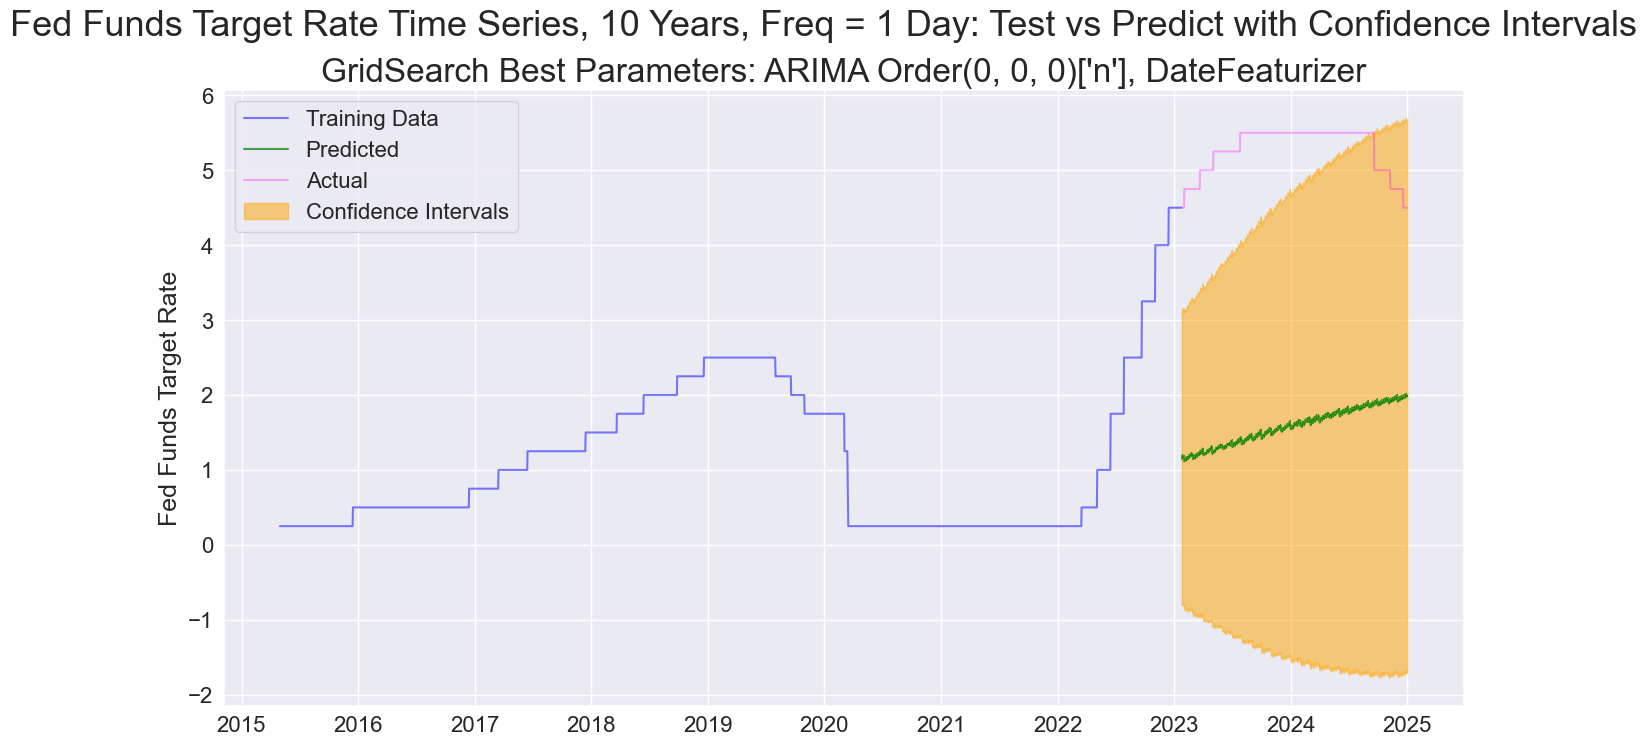

In [87]:
pam_fed_funds_target_10Y = Pmdarima_Model(fed_t_10Y_df, 'Fed Funds Target Rate', order=(0,1,0), trend='t',
               n=10, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=False, box=False, log=False)
pam_fed_funds_target_10Y_best, scores = pam_fed_funds_target_10Y.run_gridsearch_CV(min_order=0, max_order=1, min_d=0, max_d=1, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', #f_m=252, k=2,
                                    date=True, fourier=False, box=False, log=False, debug=True, verbose=1, parallel=False)

### TBATS

In [88]:
if __name__ == '__main__':
    tb = tbats.TBATS(seasonal_periods=(3*30.436875, 365.25))
    tb

In [89]:
# X_train, X_test, y_train, y_test = train_test_split(spy_df_3Y.close, test_size = .20, random_state = 729)
train, test = train_test_split_data(spy_df_10Y.close, train_size = 80)
train, test

(date
 2015-05-01    176.183601
 2015-05-04    177.723263
 2015-05-05    177.554977
 2015-05-06    176.318244
 2015-05-07    174.938384
                  ...    
 2023-05-05    398.007418
 2023-05-08    401.959169
 2023-05-09    400.168190
 2023-05-10    402.844913
 2023-05-11    400.966347
 Freq: C, Name: close, Length: 2022, dtype: float64,
 date
 2023-05-12    402.397130
 2023-05-15    401.229133
 2023-05-16    400.878766
 2023-05-17    401.355749
 2023-05-18    403.837679
                  ...    
 2025-05-12    581.469971
 2025-05-13    583.409973
 2025-05-14    587.809998
 2025-05-15    585.559998
 2025-05-16    591.250000
 Freq: C, Name: close, Length: 505, dtype: float64)

In [113]:
tb_mod = tb.fit(train)

MAE (in sample): 2.183468763452078
MAE (forecast): 108.45015463475158


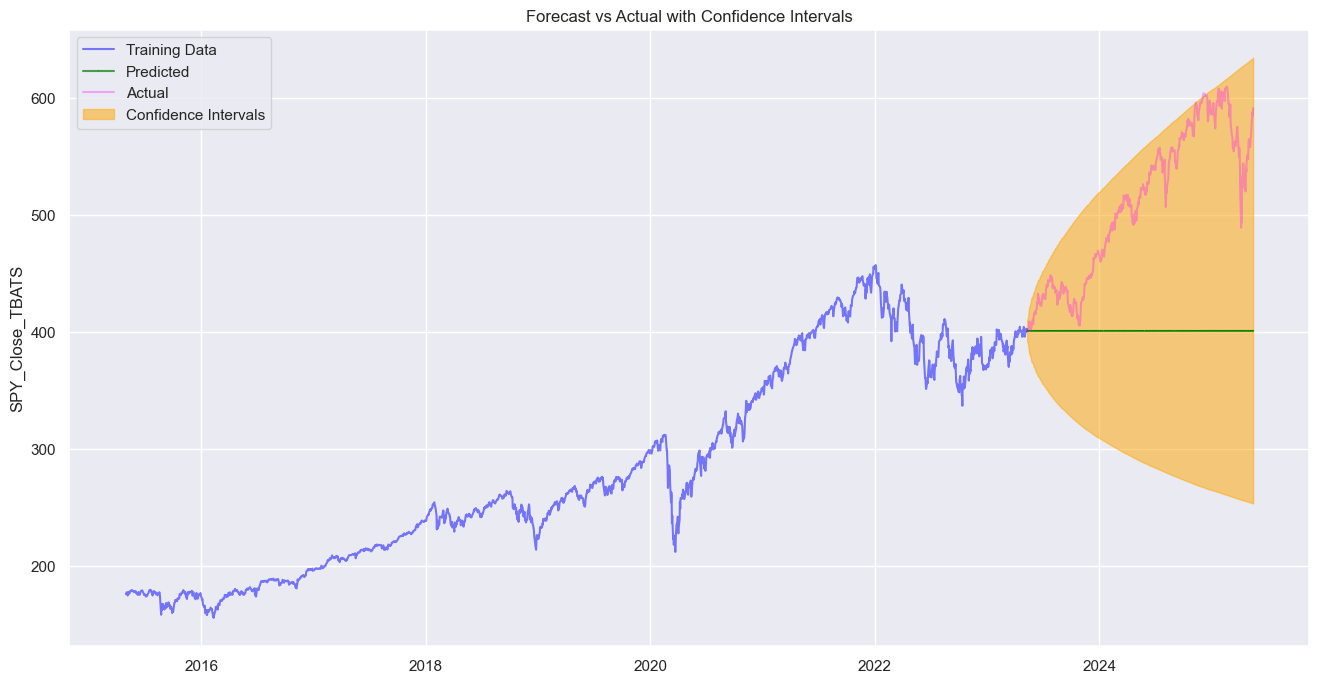

In [119]:
y_hat, conf_ints = tb_mod.forecast(steps=len(test), confidence_level=0.95)
y_hat_series = pd.Series(y_hat, index=test.index)

lower_series = pd.Series(conf_ints['lower_bound'], index=test.index)
upper_series = pd.Series(conf_ints['upper_bound'], index=test.index)

mae_in_sample = np.mean(np.abs(tb_mod.resid))
mae_forecast = mean_absolute_error(test, y_hat_series)

print('MAE (in sample):', mae_in_sample)
print('MAE (forecast):', mae_forecast)

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train.index, train, color='blue', alpha=0.5, label='Training Data')
ax.plot(test.index, y_hat_series, color='green', marker=',', alpha=0.7, label='Predicted')
ax.plot(test.index, test, color='magenta', alpha=0.3, label='Actual')

ax.fill_between(test.index,
                lower_series,
                upper_series,
                alpha=0.5, color='orange',
                label='Confidence Intervals')

ax.legend(loc='upper left')
ax.set_ylabel('SPY_Close_TBATS')
ax.set_title('Forecast vs Actual with Confidence Intervals')

plt.show()

### Logistic Regression

In [120]:
y_forecasted = tb_mod.forecast(steps=14)

In [121]:
y_forecasted

array([401.08699085, 401.08699085, 401.08699085, 401.08699085,
       401.08699085, 401.08699085, 401.08699085, 401.08699085,
       401.08699085, 401.08699085, 401.08699085, 401.08699085,
       401.08699085, 401.08699085])

### SPY vs SPY Future with No Offset

In [122]:
X, y = create_data_sets(spy_f_df_3Y, spy_df_3Y, verbose=1)

X:
              f_open   f_high    f_low  f_close  f_adj_close  change
date                                                               
2022-05-02  4151.00  4165.75  4056.00  4144.00      2351404       0
2022-05-03  4169.25  4195.75  4129.00  4145.50      1678497       1
2022-05-04  4295.25  4303.00  4142.75  4171.25      1783477       1
2022-05-05  4143.25  4300.75  4099.25  4289.75      2389422       1
2022-05-06  4119.50  4153.25  4062.00  4146.50      2310919       0
...             ...      ...      ...      ...          ...     ...
2025-05-12  5865.00  5876.25  5734.25  5761.00      1765593       1
2025-05-13  5904.50  5927.00  5835.75  5868.00      1335457       1
2025-05-14  5908.50  5925.00  5890.00  5902.00      1207202       1
2025-05-15  5933.25  5944.50  5867.00  5904.00      1291986       0
2025-05-16  5975.50  5977.50  5923.00  5935.00      1291986       1

[764 rows x 6 columns]
y:
 date
2022-05-02    0
2022-05-03    1
2022-05-04    1
2022-05-05    1
2022-05-06    0

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 729)
X_y_train_test = train_test_split(X, y, test_size = .20, random_state = 729)
X_y_train_test[0]

,f_open,f_high,f_low,f_close,f_adj_close,change
date,,,,,,
2022-11-02,3768.75000,3907.00,3760.25000,3863.00,2210708,0
2022-09-01,3968.75000,3971.25,3903.50000,3958.00,2212034,0
2022-08-26,4059.50000,4217.25,4042.75000,4198.25,2241117,1
2024-11-05,5812.25000,5823.25,5735.00000,5752.25,1198797,0
2022-10-03,3690.25000,3711.75,3571.75000,3593.25,2315515,0
...,...,...,...,...,...,...
2022-06-17,3663.76001,3710.75,3663.76001,3677.50,2207570,0
2024-06-17,5478.50000,5494.00,5424.75000,5435.50,1589643,1
2023-04-03,4153.75000,4157.75,4122.75000,4127.00,1380286,1


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler())]),
                                                  Index(['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'change'], dtype='object'))])),
                ('lr', LogisticRegression(max_iter=500, random_state=1))])
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
{'lr__C': 0.01, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__l1_ratio': None, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
Classifier:  LogisticRegression
Num features:  6
Model score:  1.0
Accuracy score:  1.0
Model F1 (micro):  1.0
Model F1 (macro):  1.0
Model F1 (weighted):  1.0
Cross validation score:  [0.58064516 0.58064516 0.5483871  0.43333333 0.43333333]
Classification Report:
              precision    recall  f1-score   support

           0     

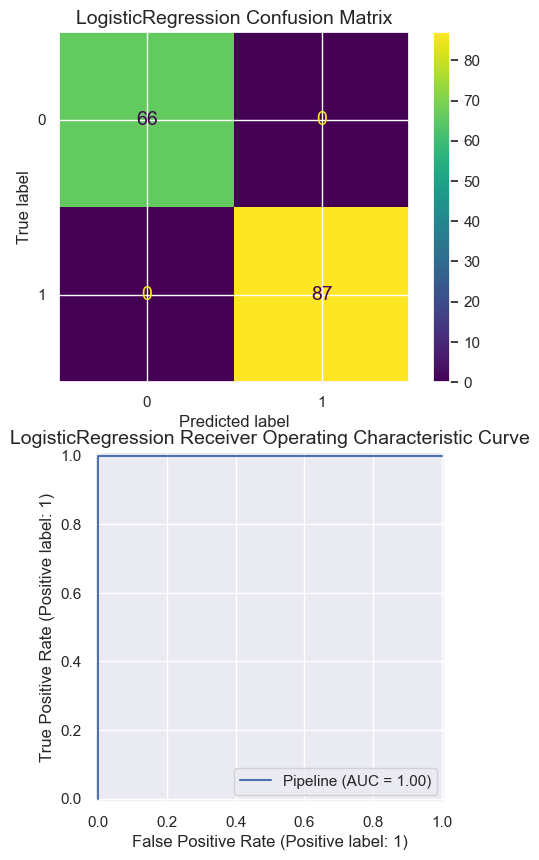

In [136]:
model, y_hat = run_model_gridsearch_CV(X_y_train_test, clf_type='log', verbose=1)

In [147]:
X = spy_cat_3Y_df.drop(['close', 'adj_close', 'open', 'high', 'low'], axis=1)
X = X.drop(X.index[0], axis=0)
# y = y_setup.drop(y_setup.index[0]).change
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = .20,
        random_state = 729)
print (X,y)

             f_open   f_high    f_low  f_close  f_adj_close
date                                                       
2022-05-03  4169.25  4195.75  4129.00  4145.50      1678497
2022-05-04  4295.25  4303.00  4142.75  4171.25      1783477
2022-05-05  4143.25  4300.75  4099.25  4289.75      2389422
2022-05-06  4119.50  4153.25  4062.00  4146.50      2310919
2022-05-09  3987.50  4099.00  3970.00  4087.25      2139992
...             ...      ...      ...      ...          ...
2025-05-12  5865.00  5876.25  5734.25  5761.00      1765593
2025-05-13  5904.50  5927.00  5835.75  5868.00      1335457
2025-05-14  5908.50  5925.00  5890.00  5902.00      1207202
2025-05-15  5933.25  5944.50  5867.00  5904.00      1291986
2025-05-16  5975.50  5977.50  5923.00  5935.00      1291986

[763 rows x 5 columns] 0      1
1      1
2      1
3      0
4      0
      ..
758    1
759    1
760    1
761    0
762    1
Name: change, Length: 763, dtype: int32


In [148]:
y.isna().sum()

0

In [149]:
numerical_pipeline = Pipeline(steps=[
    ('rs', RobustScaler())
])
                
# categorical_pipeline = Pipeline(steps=[
#     ('ohe', OneHotEncoder( #drop='first',
#                          sparse=False,
#                          handle_unknown='ignore'))
# ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train.columns),
#     ('categorical', categorical_pipeline, X_train.columns)
])

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler())]),
                                                  Index(['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close'], dtype='object'))])),
                ('lr', LogisticRegression(max_iter=500, random_state=1))])
Fitting 5 folds for each of 9600 candidates, totalling 48000 fits
{'lr__C': 206.913808111479, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  5
Model score:  0.6666666666666666
Accuracy score:  0.6666666666666666
Model F1 (micro):  0.6666666666666666
Model F1 (macro):  0.6533386645341863
Model F1 (weighted):  0.6573370651739304
Cross validation score:  [0.61290323 0.58064516 0.5483871  0.63333333 0.63333333]
Classifica

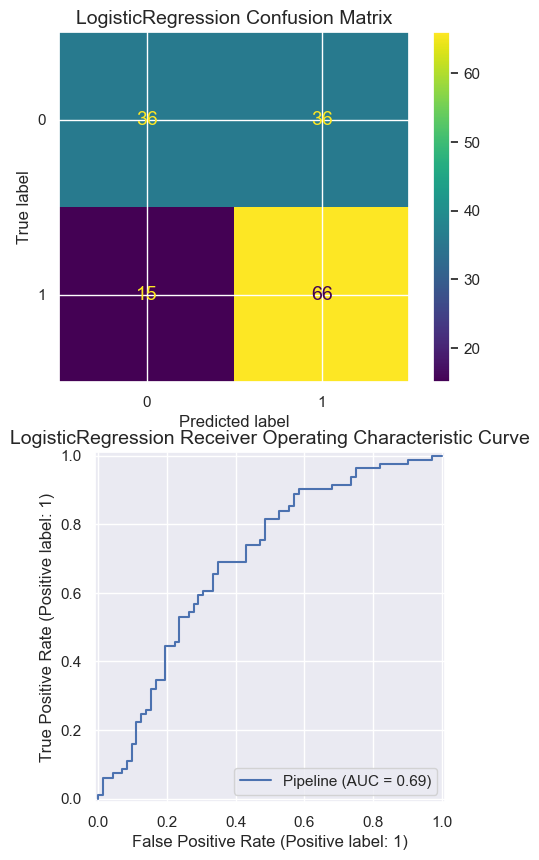

In [151]:
pipe_lr = Pipeline(steps=[
    ('trans', trans),
    ('lr', LogisticRegression(random_state=1, max_iter=500))
])
print(pipe_lr)

params_grid_lr = {'lr__penalty' : ['l1', 'l2','elasticnet'],
                  'lr__class_weight' : ['balanced', 'none'],
                  'lr__dual' : [True, False],
                  'lr__solver' : ['lbfgs', 'liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=4, n_jobs=-1)

lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train.columns, best_lr_clf, 'LogisticRegression', X_test, y_test, binary=True)

### Forecasting
#### PmdArima

Successfully created instance of Class Pmdarima_Model.
Starting AutoARIMA...
Data set diffs to use: 1


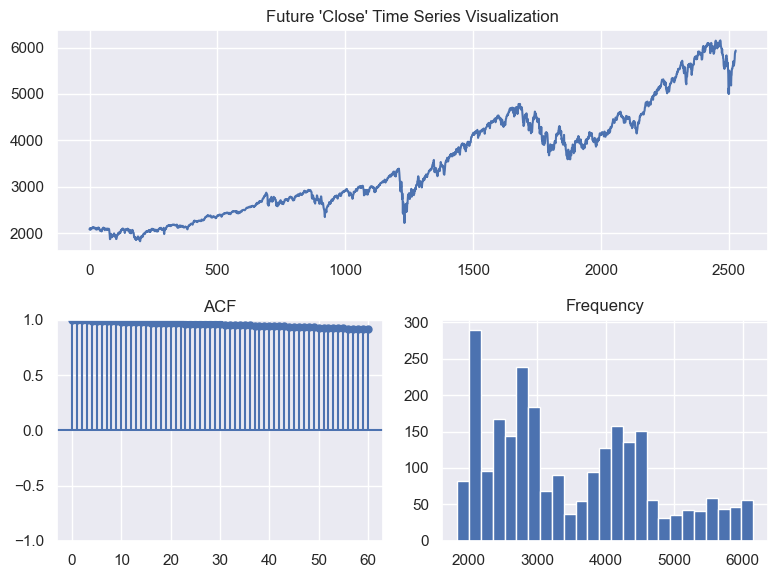

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20335.344, Time=6.08 sec
First viable model found (20335.344)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20408.244, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20398.328, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20398.748, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20407.713, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20401.751, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20401.773, Time=2.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=20337.080, Time=5.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=20393.247, Time=5.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20399.832, Time=1.11 sec
 ARIMA

Step-Wise Prediction Loop:   0%|          | 0/506 [00:00<?, ?it/s]

>_
Done.
Test AIC: 25965.582
Test RMSE: 55.105
This is 1.799% of the avg observed value.
Test SMAPE: 0.705%

Saved best AutoARIMA model as C:\Users\rafli\Spyder ETF Projection/models/Future_'Close'_10Y_1D_AA_best_model.pkl.



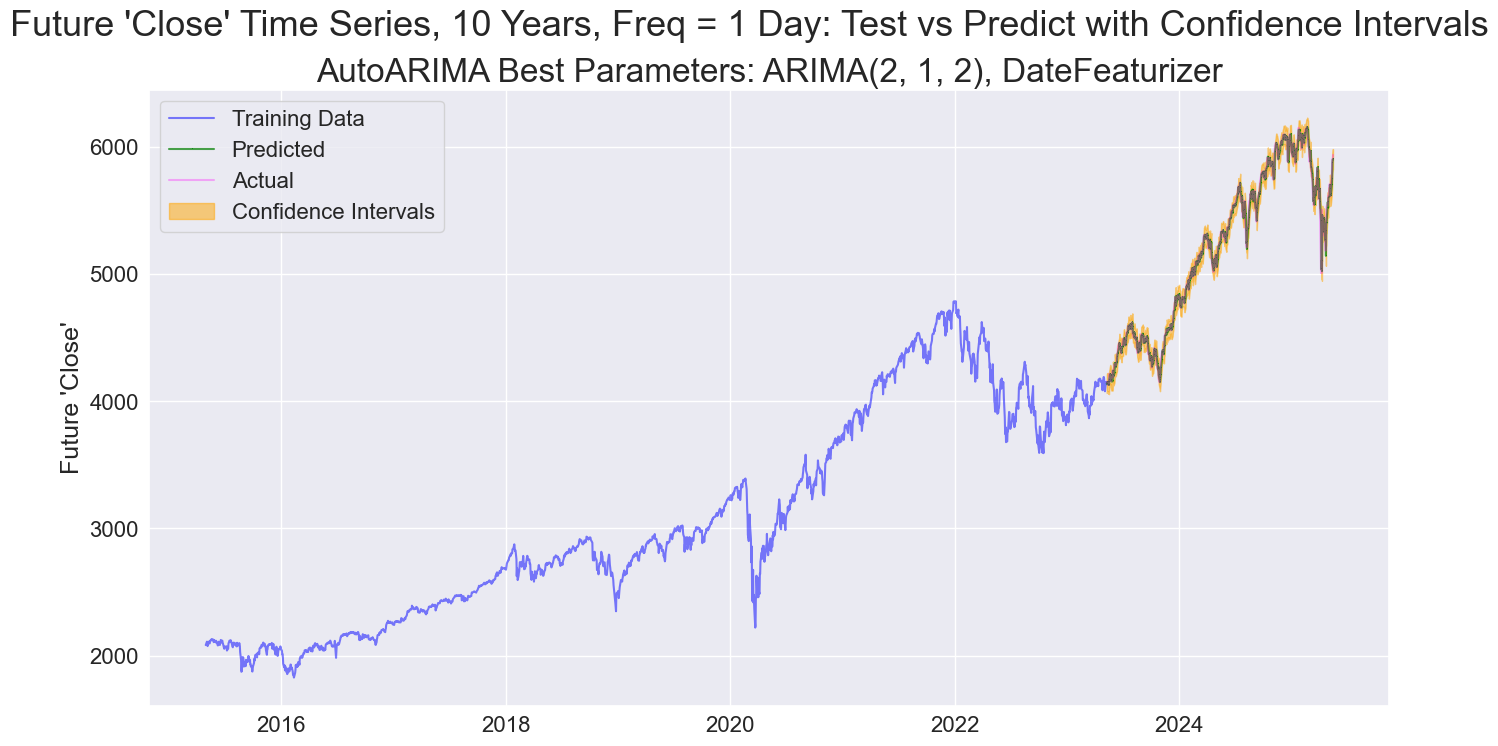

In [154]:
pam_f_close = Pmdarima_Model(df_f_10Y_close, 'Future \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=False, box=False, log=False)
pam_f_close_auto = pam_f_close.run_auto_pipeline(show_summary=True, verbose=1, visualize=False)
pAA_CV_scores = pam_f_close.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

### All Years, 10 Year Treasury Note

In [155]:
pam_tsy_all_10Y = Pmdarima_Model(tsy_all_df_10Y, 'TSY 10Y Note', order=(0,1,0), trend='c', with_intercept=False,
               n='All', periods='years', freq='1 Day', f_seas=252*4, k=2, fit_seas=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, 
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


In [156]:
pam_tsy_all_10Y_best = pam_tsy_3Y_10Y_best

In [164]:
tsy_all_10Y_hat_df, tsy_all_10Y_hat, new_dates_df, tsy_all_10Y_conf_ints = pam_tsy_all_10Y.run_prediction(pam_tsy_all_10Y_best, 52, fin=False,
                            en_ex='exog', func='adhoc', verbose=1, visualize=True)

Running Fit and Predict on Exogenous variable TSY 10Y Note...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


## Testing

In [167]:
opt_exp_10Y_df = create_option_expiry_df(date_index=spy_df_10Y.index, func='historical', freq=CBD)
opt_exp_fc_df = create_option_expiry_df(N=52, func='forecast', freq=CBD)

In [168]:
spy_10Y_mod_data = unpickle_data('../models/SPY_\'Close\'_3Y_1D_GS_best_model.pkl')

In [169]:
pam_10Y_close_best = spy_10Y_mod_data[1]

In [171]:
exog_10Y_fc_df = opt_exp_fc_df
exog_10Y_hist_df = opt_exp_10Y_df

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


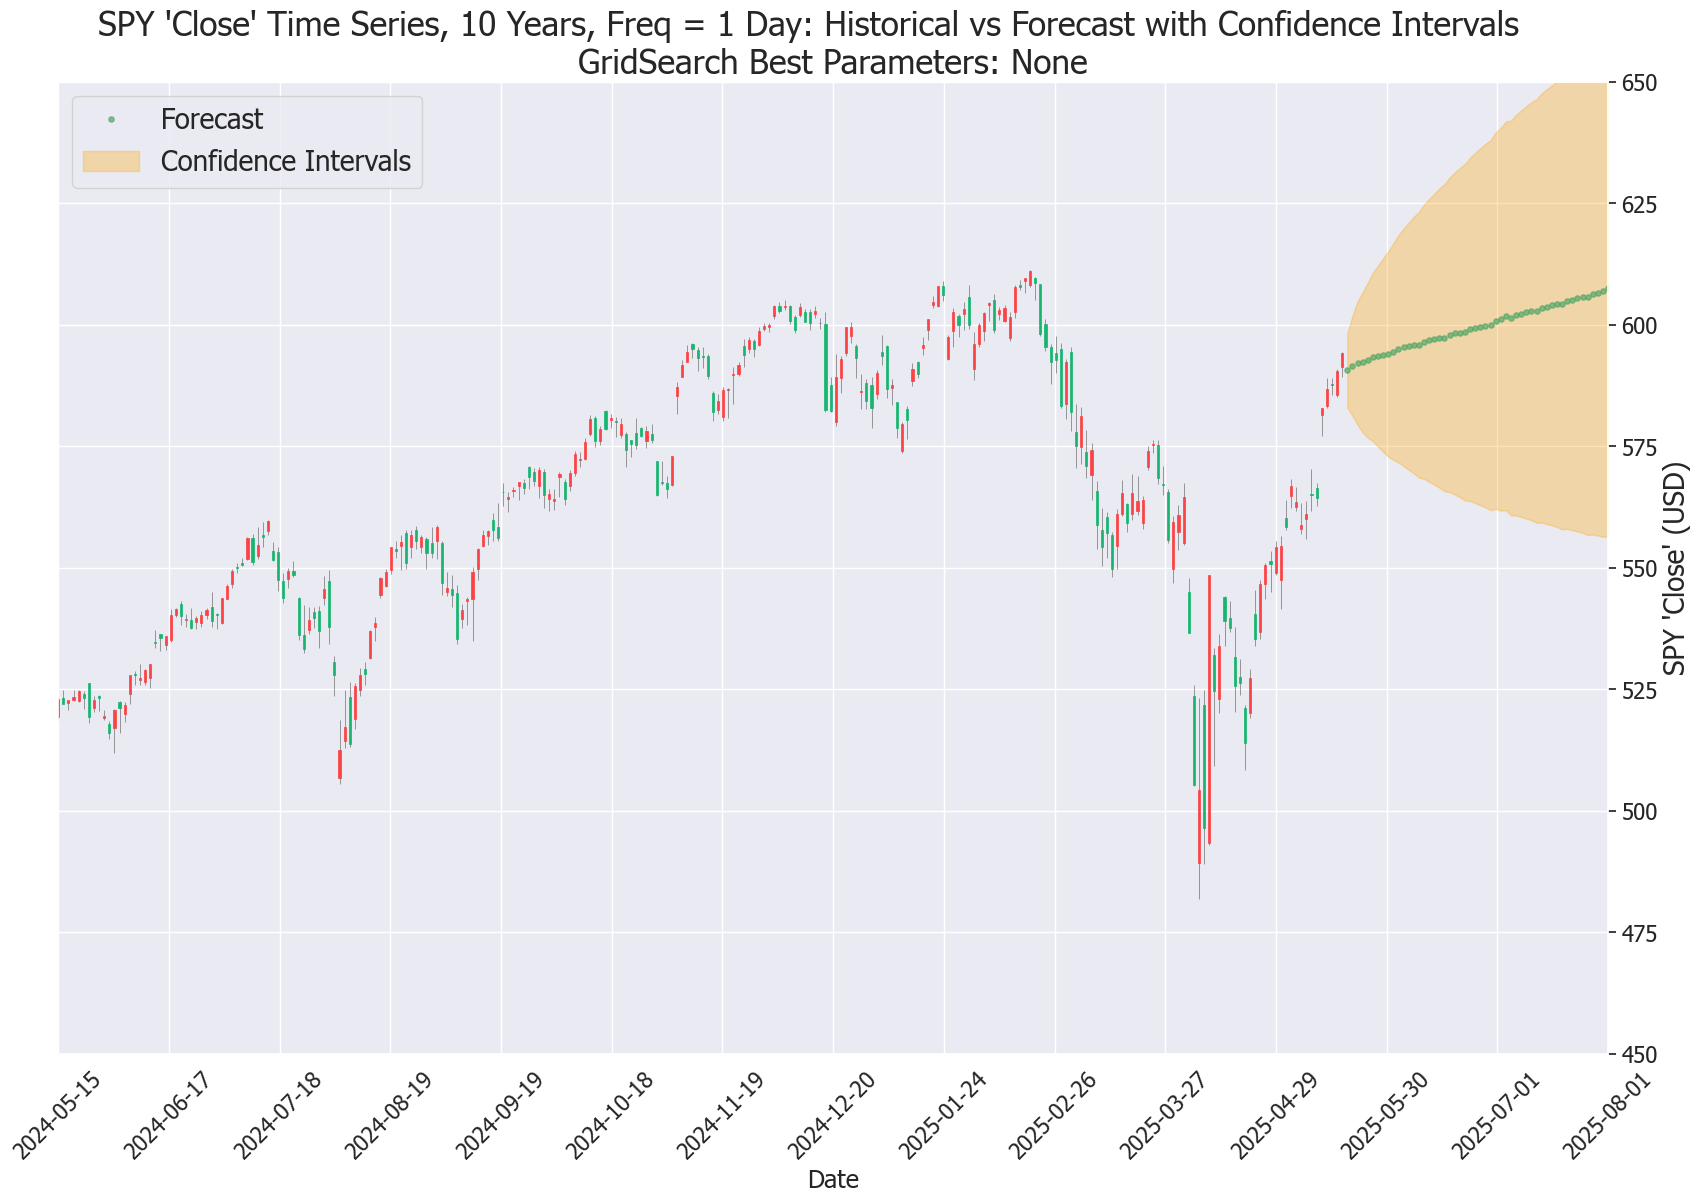

In [179]:
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=False, box=False, log=False)
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(pam_10Y_close_best, 52, fin=True,exog_fc_df=exog_10Y_fc_df,
                                                                                                  exog_hist_df=exog_10Y_hist_df,en_ex='endo',ohlc_df=spy_df_10Y,func='GS',
                                                                                                  lookback=252,verbose=1,visualize=True)

In [180]:
(close_10Y_conf_ints[0][1] - close_10Y_conf_ints[0][0])/df_10Y_close[-1]

0.025700205748057623

In [183]:
new_mod2 = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=2, m=252)),
                ('fourier2', pm.preprocessing.FourierFeaturizer(k=2, m=252*4)),
                ('fourier3', pm.preprocessing.FourierFeaturizer(k=2, m=252/4)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])

Successfully created instance of Class Pmdarima_Model.
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('fourier2', FourierFeaturizer(k=2, m=1008)),
                ('fourier3', FourierFeaturizer(k=2, m=63.0)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


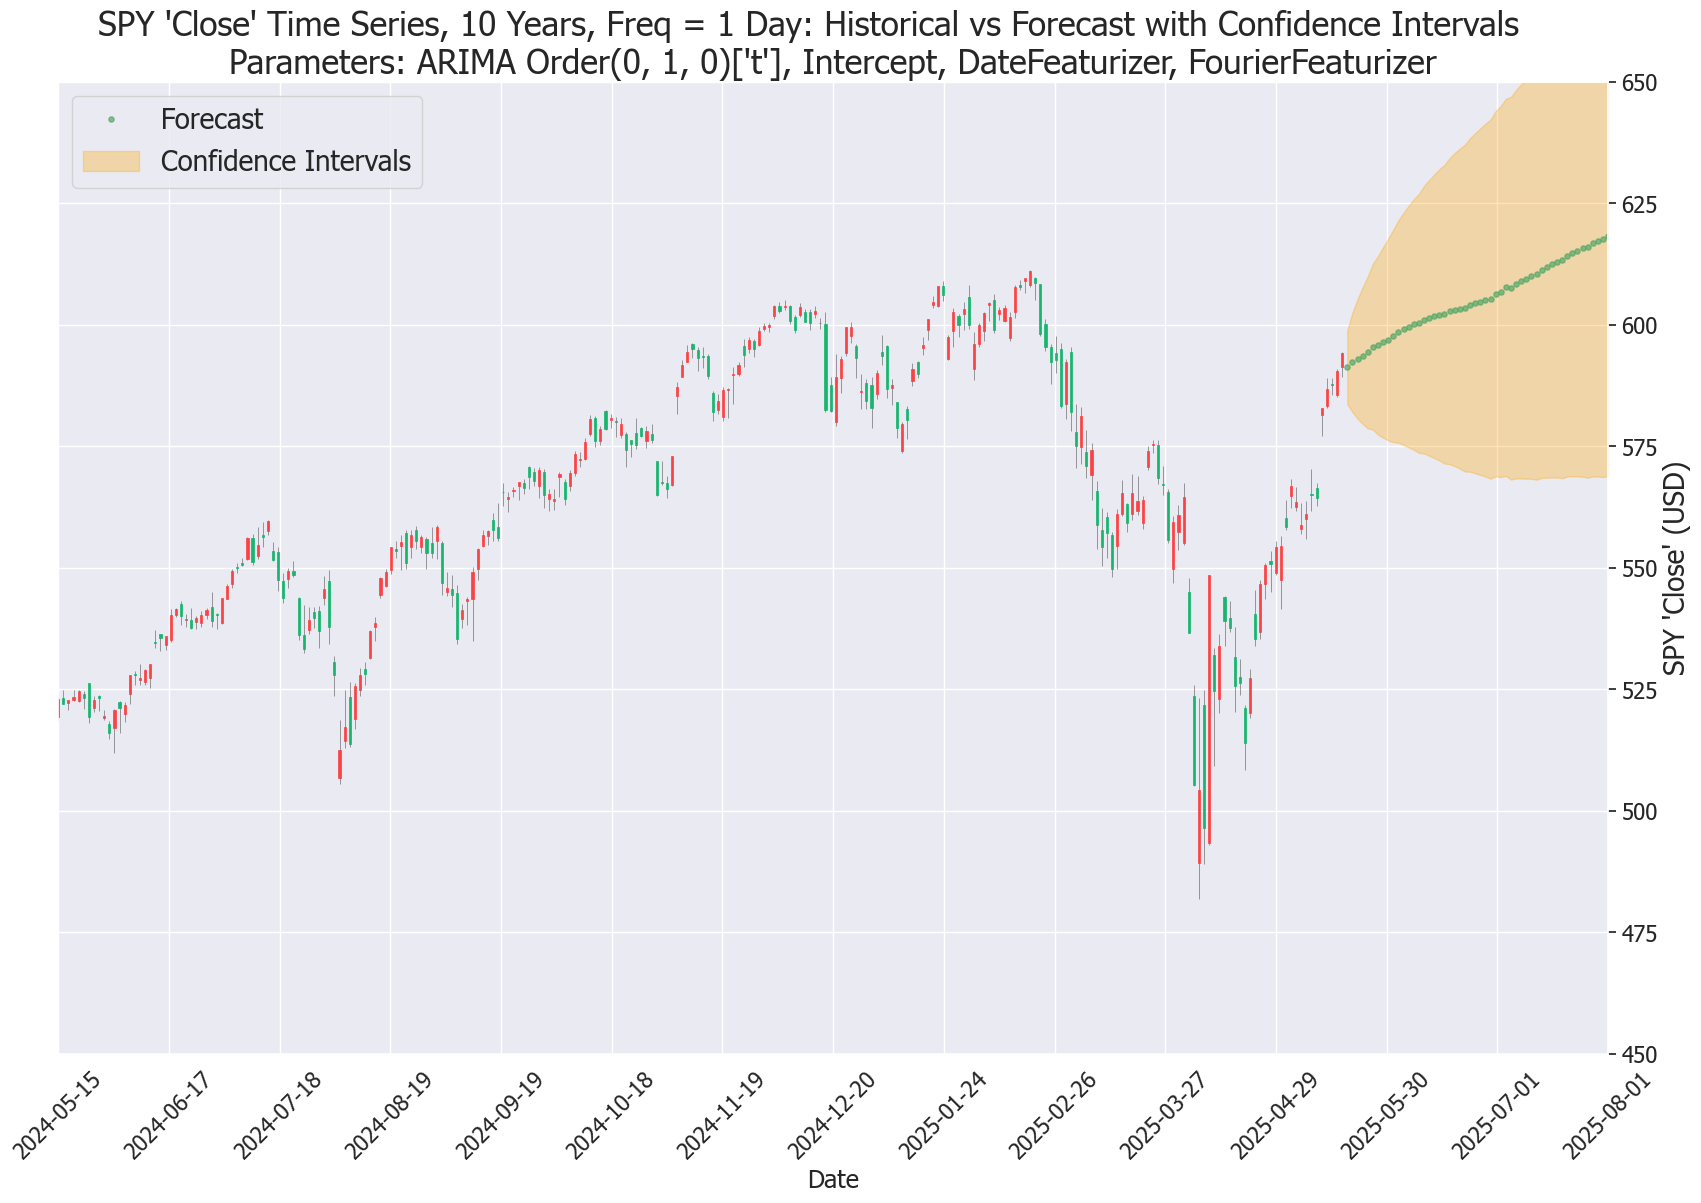

In [185]:
# lower order model with three seasonalities
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80, order=(0,1,0),
                            n=10, periods='years', freq='1 Day', seas=252, trend='t', with_intercept=True,
                            estimate_diffs=True, impute=False, verbose=1, f_seas=252, k=2,
                            date=True, fourier=True, box=False, log=False)
print(new_mod2)
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(
                model=new_mod2, days_fc=52,fin=True,exog_fc_df=exog_10Y_fc_df,exog_hist_df=exog_10Y_hist_df,en_ex='endo',
                ohlc_df=spy_df_10Y, func='adhoc',lookback=252,verbose=1,visualize=True
)

In [186]:
(close_10Y_conf_ints[0][1] - close_10Y_conf_ints[0][0])/df_10Y_close[-1]

0.025665214184951633